# Postmating response in axenic and control _D. melanogaster_ females

Load packages and functions:

In [1]:
## Packages to load
req_packages = c("AnnotationHub", "AnnotationDbi", "Biobase", "circlize", "cluster", "clusterProfiler", "ComplexHeatmap", "cowplot", 
                 "cummeRbund" , "data.table", "DOSE", "EDASeq", "edgeR", "enrichplot", "gage", "genefilter", "ggpubr", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", "lattice", 
                 "imager", "org.Dm.eg.db", "pheatmap", "qvalue", "RColorBrewer", "RSkittleBrewer",
                 "reshape", "Rmisc", "RUVSeq","splitstackshape", "statmod", "stringr", "sva", "tidyverse",
                 "VennDiagram", "viridis")
## load them, quietly
invisible(suppressWarnings(suppressMessages(
    lapply(req_packages, require, character.only = TRUE)
)))

## The Cowplot package changes the default themes of ggplot2. Set the bw theme with larger font sizes like so:
theme_set(theme_bw(base_size = 16))
## ... or set the default theme
# theme_set(theme_gray())

## suppress excessive VennDiagram log files
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

NULL

Load custom functions:

In [2]:
source("Functions.R")

Some raw files need to be processed to produce auxiliary files needed below. Running a script in the "Misc" folder should do it:

In [3]:
# system('./Misc/initial_file_modifications.sh')

Load the FlyAtlas2 expression data:

In [4]:
tpm.table_fa2 = read.csv("Annotoations/FlyAtlas2_TPM_table.txt", header = T, sep = "\t")
tpm.matrix_fa2 = read.csv("Annotoations/FlyAtlas2_meanTPM_table.txt", header = T, sep = "\t", row.names = 1)

Calculate tao for a select subset of female tissue:

In [5]:
desired_fa2_columns = c("Female_Anal_Pad", "Female_Crop", "Female_Salivary_Gland", "Female_Midgut", "Female_Hindgut",
                           "Female_Tubule", "Female_Brain", "Female_Eye", "Female_Head",
                           "Female_Thoracicoabdominal_Ganglion", "Female_Virgin_Spermatheca",
                           "Female_Mated_Spermatheca", "Ovary", "Female_Carcass")
tpm.matrix_fa2.female_tissues = subset(tpm.matrix_fa2, select = desired_fa2_columns)
fem_tao = suppressWarnings(as.data.frame(calcSpecificity(matrix = tpm.matrix_fa2.female_tissues, pseudocount = 1)))

... and the associated sample information:

In [6]:
sample.info = read.table("Misc/SraRunTable_FlyAtlas2_modified.txt", header = T, sep = "\t")
sample.info = filter(sample.info, RNA == "mRNA")
sample.info = select(sample.info, Library_Name, Replicate_Name, Sex, dev_stage, organism_part, Sample_Name)
sample.info$Library_Name = gsub("Female ", "", sample.info$Library_Name)
sample.info$Library_Name = gsub("Male ", "", sample.info$Library_Name)
sample.info$Library_Name = gsub("Larval ", "", sample.info$Library_Name)
sample.info$Sex = gsub("NA", "unknown", sample.info$Sex)

Load read count data:

In [8]:
baseCounts = read.table("eXpress/express.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)
counts_bt2 = baseCounts
colnames(counts_bt2) = gsub("O", "", colnames(counts_bt2))

Load annotation files:

In [9]:
annotation = read.csv("Annotoations/fbgn_annotation_ID_fb_2018_04_mod.tsv", header = T, check.names = F, sep ="\t")

Load the gene snapshot data:

In [10]:
snapshots = read.csv("Annotoations/gene_snapshots_fb_2018_05.tsv", header = T, sep ="\t", quote = "")

Load the Uniprot IDs:

In [11]:
aux_IDs = read.csv("Annotoations/fbgn_auxiliary_ids.txt", header = T, sep ="\t", na.string = "")

Load the GO information for GOseq (if we use it):

In [12]:
GO_associations = read.csv("Annotoations/GO_associaations.fb", header = T, sep ="\t")
GO_info = aggregate(term~FBgn_ID, data = GO_associations, toString)
rownames(GO_info) = GO_info$FBgn_ID
GO_info = subset(GO_info, select = "term")
GO_info$term = gsub(", ", ",", GO_info$term)

To perform GO analyses with clusterProfiler, we need to obtain the EntrezIDs:

In [13]:
melAnnDb <- org.Dm.egFLYBASE
mapped_IDs <- mappedkeys(melAnnDb)
as.list(melAnnDb[mapped_IDs]) %>% unlist() %>% as.data.frame() -> Entrez_mappings
Entrez_mappings$ent_id = rownames(Entrez_mappings)
as_tibble(Entrez_mappings) %>% rename(FBgn_ID = ".") -> Entrez_mappings

Load the known immunity genes from Sackton *et al* 2008:

In [14]:
immunity_genes.df = read.csv("Annotoations/mel_immunity_genes.txt", header = T, sep = "\t", check.names = F)
immunity_genes = as.character(immunity_genes.df$FlyBaseID)

Load the transcript lengths for the eXpress data:

In [15]:
bt2_trans_lengths = read.csv("eXpress/transcriptome/transcript_lengths.txt", header = T, sep = "\t")

Load the gene-to-transcript mapping:

In [16]:
gene_trans_map = read.table("eXpress/transcriptome/dmel-all-transcript-r6.23.gene_trans_map", header = F, sep = "\t")
colnames(gene_trans_map) = c("gene_id", "transcript_id")

Generate a gene length object for the eXpress data:

In [17]:
# Merge transcript length file with gene-to-trans file:
tmpMrge = merge(bt2_trans_lengths, gene_trans_map)
# Select only the length and gene_id columns
tmpMrge = as.data.table(subset(tmpMrge, select = c("length", "gene_id")))
# For each gene ID entry, select the entry with largest value in the "length" column:
bt2_gene_lengths = as.data.frame(tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1])
# assign gene names to rownames
rownames(bt2_gene_lengths) <- bt2_gene_lengths$gene_id
# # select the length column only
bt2_gene_lengths = subset(bt2_gene_lengths, select = "length")
# remove un-needed intermediate objects
rm(tmpMrge)

For GO analyses we need to create a couple of objects:

In [18]:
GO_info_listed = apply(GO_info, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GO_info)
features_with_GO = rownames(GO_info)
lengths_features_with_GO = bt2_gene_lengths[features_with_GO,]

Generate sample info object:

In [22]:
sampleData = read.table("Misc/samples.txt", header = F, check.names = F, fill = T)
sampleInfo = sampleData
colnames(sampleInfo) = c("Sample", "Replicate")

sampleInfo$Female = ifelse(grepl("^A",sampleInfo$Sample), "axenic", "control")

sampleInfo$Male = ifelse(grepl("A$", sampleInfo$Sample), "axenic", ifelse(grepl("C$", sampleInfo$Sample), "control", "none"))

sampleInfo$Handler = ifelse(grepl("3|4", sampleInfo$Replicate), "Yasir", "Sofie")

sampleInfo$Status = ifelse(grepl("none", sampleInfo$Male), "virgin", "mated")

sampleInfo$Sample = gsub("O", "", sampleInfo$Sample)
sampleInfo$Replicate = gsub("O", "", sampleInfo$Replicate)
SampleInfo = sampleInfo

Generate a TPM table from the counts. Use any arbitrary number for lengths since this is 3prime data:

In [24]:
tpm_bt2 <- apply(counts_bt2, 2, function(x) tpm(x, 2000))

Reshape the TPM matrix to calculate means and generate heatmaps and individual gene plots later:

In [25]:
tmp.tpmMatrix<-tpm_bt2
# colnames(tmp.tpmMatrix) <- sampleInfo$Sample
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate", "TPM")
tmp.tpmMatrix.m <- merge(tmp.tpmMatrix.m, sampleInfo, by.x = "replicate", by.y = "Replicate", all.x = T)
tmp.tpmMatrix.m$replicate = gsub(".*_", "", tmp.tpmMatrix.m$replicate)
annot.sub = subset(annotation, select = c("primary_FBgn", "gene_symbol", "annotation_ID"))
tmp.tpmMatrix.m = merge(tmp.tpmMatrix.m, annot.sub, by.x = "gene_id", by.y = "primary_FBgn", all.x = T)
# tmp.tpmMatrix.m = merge
tpm.table = tmp.tpmMatrix.m
tpm.table$Male = factor(tpm.table$Male, levels = c("none", "axenic", "control"))
tpm.table$Status = factor(tpm.table$Status, levels = c("virgin", "mated"))
rm(tmp.tpmMatrix.m)

We'll make a mean TPM matrix:

In [26]:
# tpmSE = summarySE(tpm.table, measurevar = "TPM", groupvars = c("gene_id", "Sample", "Female", "Male", "Handler", "Status", "gene_symbol", "annotation_ID"))

# write.table(tpmSE, "eXpress/tpmSE.txt", quote = F, sep = "\t", row.names = F)
tpmSE = read.table("eXpress/tpmSE.txt", header = T, sep = "\t")

tmpMat<-cast(tpmSE, gene_id~Sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_mean <- tmpMat[,-1]
rownames(tpmMatrix_mean) <- tmpMat[,1]
rm(tmpMat)

the `geneBoxPlot` function can be used for single gene tpm boxplots of the data:

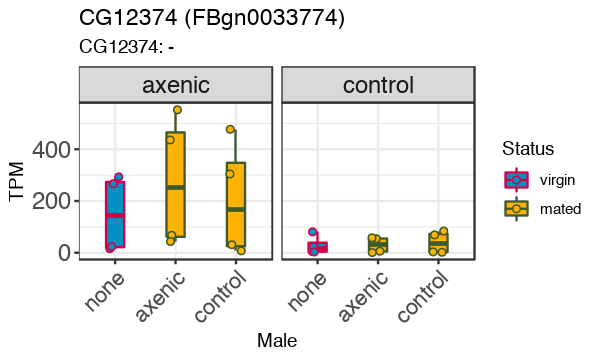

In [28]:
options(repr.plot.width = 5, repr.plot.height = 3)
geneBoxPlot_mon(tpmTable = tpm.table, "CG12374", show_reps = F) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

There's also a plotting function for the Fly Atlas data:

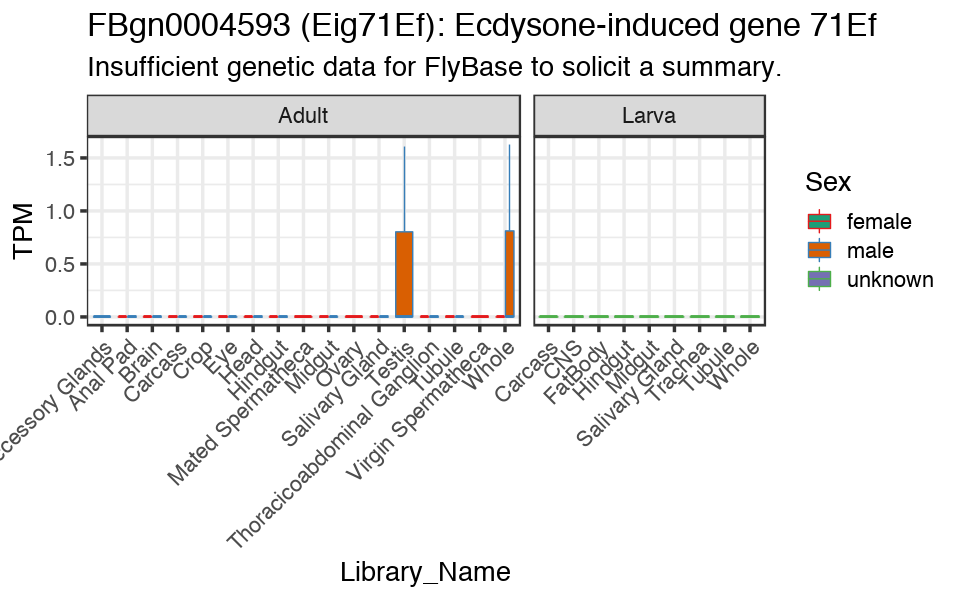

In [29]:
options(repr.plot.width = 8, repr.plot.height = 5)
geneBoxPlot_fa2(tpm.table_fa2, "FBgn0004593")

For heatmaps, we can make some modifications to the output format:

In [30]:
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 90, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

Output library size object:

In [31]:
LibSizes <- as.data.frame(colSums(counts_bt2))
libSizes <- cbind(sample = row.names(LibSizes), LibSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("replicate", "counts")
libSizes$sample = gsub("_.*", "", libSizes$replicate)
libSizes$counts = round(libSizes$counts)

Make a barplot of library sizes:

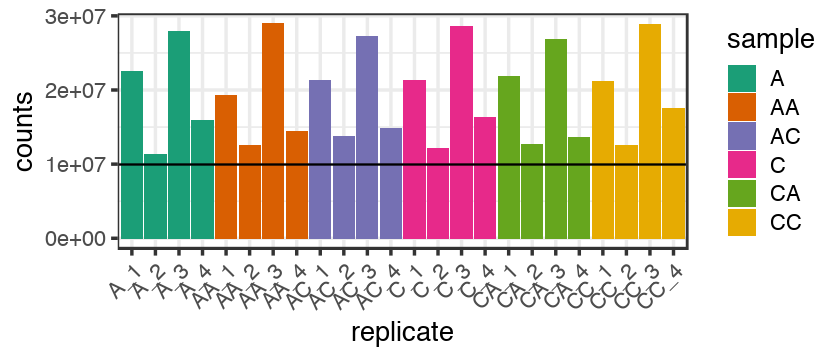

In [32]:
options(repr.plot.width = 7, repr.plot.height = 3)
# pdf("Figures/Library_sizes.pdf", width = 12, height = 4)
ggplot(libSizes, aes(replicate, counts, fill = sample)) + 
    geom_bar(stat="identity", position = "dodge") + 
#     theme_monokai_full() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    geom_hline(yintercept = 10000000) +
    scale_fill_brewer(palette="Dark2") 
# dev.off()

## Fecundity analysis:

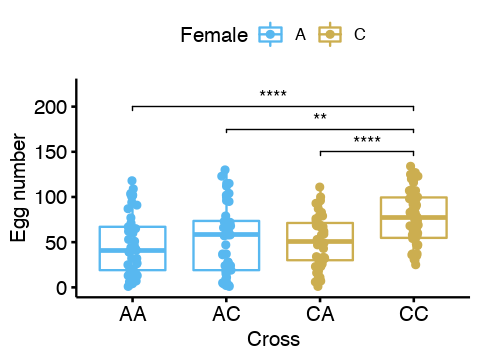

In [34]:
egg_counts <- read.csv("Fecundity-Hatchability/2019/Count_data.txt", header = T, sep = "\t")

my_comparisons <- list( c("AA", "CC"), c("AC", "CC"), c("CA", "CC") )

options(repr.plot.width = 4, repr.plot.height = 3)
ggboxplot(egg_counts, "Treatment", "Total",
    color = "Female", palette =c("#58b8f0","#ccae50"),
    add = "jitter") +
    stat_compare_means(comparisons = my_comparisons, label.y = c(200, 175, 150), aes(label = ..p.signif..)) +
    scale_y_continuous(limits = c(0, 220)) +
    labs(x = "Cross", y = "Egg number")
ggsave("Results/Figures/Fecundity_assay_boxJitter_plot.pdf", width = 4, height = 3)
ggsave("Results/manuscript_figures/Figure_1.pdf", width = 4, height = 3)

## Differential expression analysis:

First, filter out genes with very low expression from the counts matrix. We'll use a minimum cutoff of 1 CPM in at least 4 samples:

In [35]:
cpm_bt2 <- cpm(counts_bt2)
thresh_bt2 <- cpm_bt2 > 1
keep_bt2 <- rowSums(thresh_bt2) >= 4
countsKeep <- round(counts_bt2[keep_bt2,])
countsKeep_bt2 <- as.data.frame(lapply(countsKeep[1:24], as.integer))
rownames(countsKeep_bt2) <- rownames(countsKeep)
table(keep_bt2)

keep_bt2
FALSE  TRUE 
 6282  7649 

Now define the groupings by sample and set up the design matrix:

In [36]:
groups = factor(sampleInfo$Sample)
batch = factor(sampleInfo$Handler)
design = model.matrix( ~ 0 + groups)
design_batch = model.matrix( ~ 0 + groups + batch)
colnames(design_batch) <- c(levels(groups), "batch")
rownames(design_batch) <- sampleInfo$Replicate
colnames(design) <- levels(groups)
rownames(design) <- sampleInfo$Replicate

Make an expression set to input for RUVseq:

In [37]:
set <- newSeqExpressionSet(as.matrix(countsKeep_bt2), phenoData = data.frame(groups, row.names = colnames(countsKeep_bt2)))
set <- betweenLaneNormalization(set, which="upper")

Now estimate the sources of uwanted variation using RUVseq:

In [38]:
y <- DGEList(counts=counts(set), group=groups)
y <- calcNormFactors(y, method="upperquartile")
y <- estimateDisp(y, design, robust = T)
fit <- glmQLFit(y, design, robust = T)
res <- residuals(fit, type="deviance")

Use the residual to estimate the factors of unwanted variation:

In [39]:
batch_ruv_res = RUVr(set,rownames(countsKeep_bt2),k=3,res)
RUVrNormalizedCounts = normCounts(object = batch_ruv_res)
rownames(RUVrNormalizedCounts) = rownames(countsKeep_bt2)

Let's make a new TPM table with the fixed counts:

In [40]:
tpm_bt2_fixed <- apply(RUVrNormalizedCounts, 2, function(x) tpm(x, 2000))

Reshape the TPM matrix to calculate means and generate heatmaps and individual gene plots later:

In [41]:
tmp.tpmMatrix<-tpm_bt2_fixed
# colnames(tmp.tpmMatrix) <- sampleInfo$Sample
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate", "TPM")
tmp.tpmMatrix.m <- merge(tmp.tpmMatrix.m, sampleInfo, by.x = "replicate", by.y = "Replicate", all.x = T)
tmp.tpmMatrix.m$replicate = gsub(".*_", "", tmp.tpmMatrix.m$replicate)
annot.sub = subset(annotation, select = c("primary_FBgn", "gene_symbol", "annotation_ID"))
tmp.tpmMatrix.m = merge(tmp.tpmMatrix.m, annot.sub, by.x = "gene_id", by.y = "primary_FBgn", all.x = T)
# tmp.tpmMatrix.m = merge
tpm.table.rc = tmp.tpmMatrix.m
tpm.table.rc$Male = factor(tpm.table.rc$Male, levels = c("none", "axenic", "control"))
tpm.table.rc$Status = factor(tpm.table.rc$Status, levels = c("virgin", "mated"))
rm(tmp.tpmMatrix.m)

Set up a new design matrix with the unwanted factors specified:

In [42]:
design_2 <- model.matrix(~ 0 + groups + W_1 + W_2 + W_3, data=pData(batch_ruv_res))
colnames(design_2) <- gsub("groups", "", colnames(design_2))

Create the DGElist object and GLM fit:

In [43]:
dgeList <- DGEList(counts = counts(set), group = groups)
dgeList <- calcNormFactors(dgeList, method="upperquartile")
dgeList <- estimateDisp(dgeList, design_2, robust = T)
dgeList_fit <- glmQLFit(dgeList, design_2, robust = T)
summary(dgeList$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000098 0.012268 0.021010 0.041909 0.036651 4.687418 

We'll make an FBgn-to-gene symbol object to append to the tTags tables:

In [44]:
FBgn_to_symbol = subset(annotation, select = c("gene_symbol", "primary_FBgn"))

Look at BCV and QQ plot:

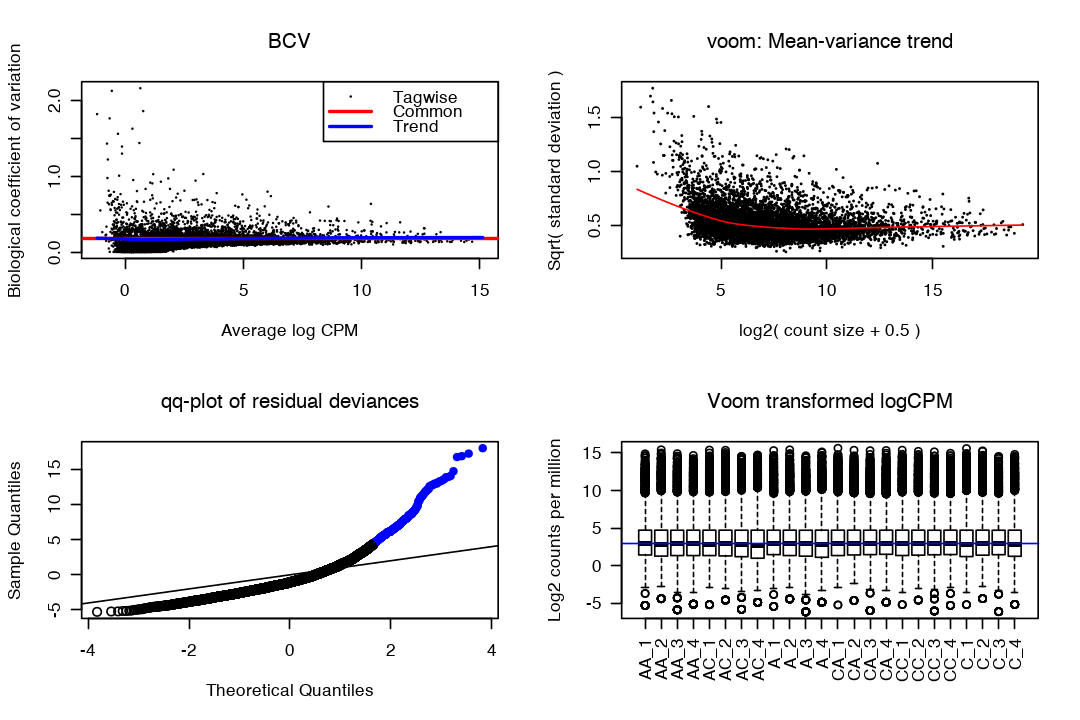

In [45]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))

# Biological coefficient of variation
plotBCV(dgeList, main = "BCV")

# mean-variance trend
voom = voom(dgeList, design_2, plot=TRUE)

# QQ-plot
gof(dgeList_fit, pcutoff = 0.05, adjust = "holm", plot = T)
# g.v <- gof(dgeList_fit, pcutoff = 0.05, adjust = "holm")
# z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
# qqnorm(z.v); qqline(z.v, col = 2,lwd=2,lty=2)

# log2 transformed and normalize boxplot of counts across samples
boxplot(voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voom$E),col="blue")

# rm(voom, g.v, z.v)


Generate a correlation plot between replicates:

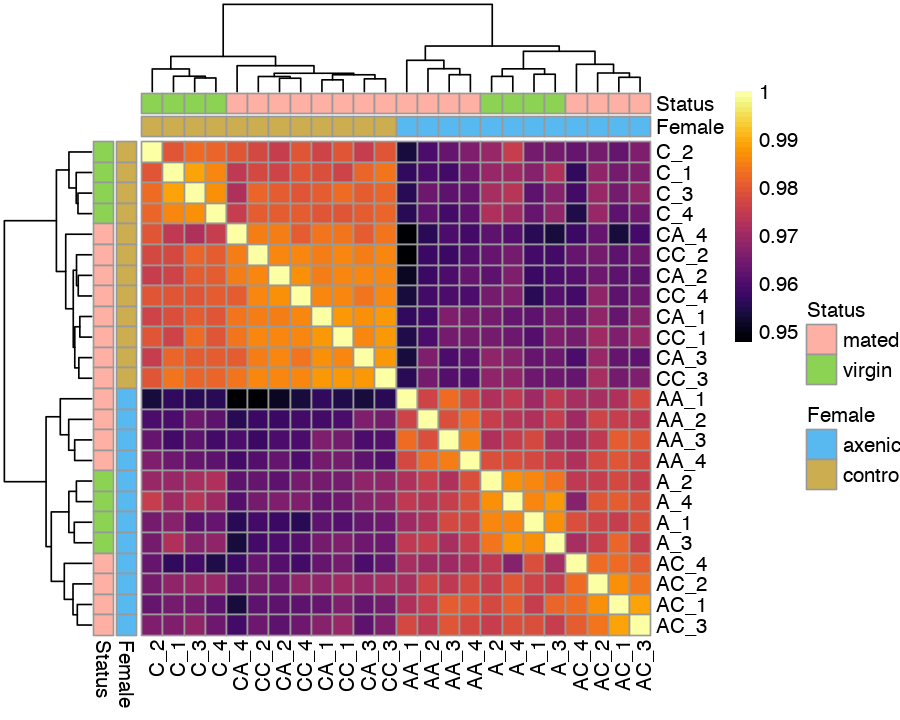

In [48]:
## Plot sample correlation
data = log2(RUVrNormalizedCounts+1)
# colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

sampleColLabeling = sampleInfo
rownames(sampleColLabeling) = sampleColLabeling$Replicate
sampleColLabeling = subset(sampleColLabeling, select = c("Female", "Status"))

cor_colors <- list(Female = c("#58b8f0","#ccae50"), Status = c("#feb0a4","#8cd253"))
names(cor_colors$Female) <- unique(sampleColLabeling$Female)
names(cor_colors$Status) <- unique(sampleColLabeling$Status)

options(repr.plot.width = 7.5, repr.plot.height = 6)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
#   border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#     drop_levels       = TRUE,
    annotation_col    = sampleColLabeling,
  annotation_row    = sampleColLabeling,
  annotation_colors = cor_colors,
#   filename          = "Results/manuscript_figures/sample_correlations_all.pdf",
#   width             = 7.5, 
#   height            = 6,
  fontsize          = 12    
)
rm(data)
rm(sample_cor)

Hmmmm.... wierd groupings by replicate. Look at an MDS plot:

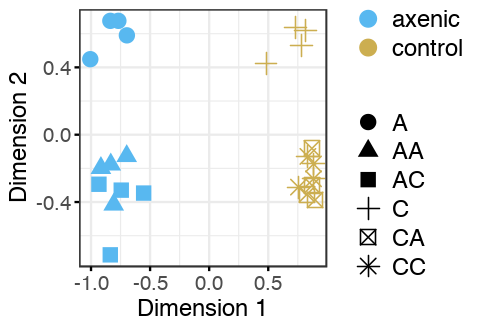

In [49]:
x <- DGEList(counts = RUVrNormalizedCounts, group = groups)
suppressWarnings(x <- calcNormFactors(x))
x <- estimateGLMCommonDisp(x, design)
x <- estimateGLMTagwiseDisp(x, design)
x <- estimateGLMTrendedDisp(x, design)

mdsObj <- plotMDS(x, plot = F)$cmdscale.out
    mdsObj <- as.data.frame(as.matrix(mdsObj))
    mdsObj$replicate <- rownames(mdsObj)
    colnames(mdsObj) = c("dim1", "dim2", "replicate")
    mdsObj = merge(mdsObj, sampleInfo, by.x = "replicate", by.y = "Replicate")
    mdsObj$replicate_num = gsub(".*_", "", mdsObj$replicate)

options(repr.plot.width = 4, repr.plot.height = 2.75)
        ggscatter(mdsObj, 
              x = "dim1", 
              y = "dim2",
              color = "Female",
              shape = "Sample",
              size = 4,
#               alpha = 0.8, 
              ggtheme = theme_bw(),
              repel = "Time",) + 
                theme(axis.text = element_text(size = 12), legend.title = element_blank(), axis.title = element_text(size = 14), legend.text = element_text(size = 14)) +
                labs ( x = "Dimension 1", y = "Dimension 2") +
             scale_color_manual(values = as.character(unlist(cor_colors$Female)))

ggsave("Results/manuscript_figures/MDS_plot.pdf", width = 4, height = 2.75)

We can look at the expression of individual genes across all our samples with barplots, e.g.:

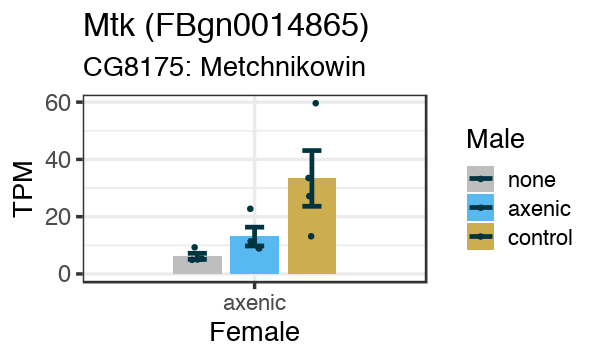

In [50]:
options(repr.plot.width = 5, repr.plot.height = 3)
myGene = "Mtk"
geneBarPlot_byFemale(tpmTable = tpm.table.rc, gene = myGene, show_reps = T)

### Contrast between virgin and mated control females:

Set up the contrasts:

In [51]:
CA.v.C_contrasts <- makeContrasts(CA-C, levels=design_2)
CC.v.C_contrasts <- makeContrasts(CC-C, levels=design_2)

Now let's look at the control females. First, females mated to axenic males

In [52]:
# run the LRT and extract the DE table
lrt.CA.v.C.table <- edge.DE(dgeList_fit, CA.v.C_contrasts, LRT = F)

CA.v.C_sigGenes = subset(lrt.CA.v.C.table, sig == "yes")$gene
CA.v.C_sigGenes_up = subset(lrt.CA.v.C.table, sig == "yes" & logFC > 1)$gene
CA.v.C_sigGenes_down = subset(lrt.CA.v.C.table, sig == "yes" & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CA.v.C_contrasts_volcano.gg = edge.DE.gg(lrt.CA.v.C.table) +
                                scale_colour_manual(values = c("grey", "#8e2381")) +
                                geom_label_repel(data = filter(lrt.CA.v.C.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3,
                                colour = "black",
                                ylim = c(6, NA)) +
                                labs(title = "control females\n(virgin vs. mated to axenic male)", size = 2) +
                                theme(axis.text.x = element_text(angle = 0), plot.title = element_text(hjust = 0.5))

... and females mated to control males

In [53]:
# run the LRT and extract the DE table
lrt.CC.v.C.table <- edge.DE(dgeList_fit, CC.v.C_contrasts, LRT = F)

CC.v.C_sigGenes = subset(lrt.CC.v.C.table, sig == "yes")$gene
CC.v.C_sigGenes_up = subset(lrt.CC.v.C.table, sig == "yes" & logFC > 1)$gene
CC.v.C_sigGenes_down = subset(lrt.CC.v.C.table, sig == "yes" & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CC.v.C_contrasts_volcano.gg = edge.DE.gg(lrt.CC.v.C.table) +
                                scale_colour_manual(values = c("grey","#5fa300")) +
                                geom_label_repel(data = filter(lrt.CC.v.C.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3,
                                colour = "black",
                                ylim = c(6, NA)) +
                                labs(title = "control females\n(virgin vs. mated to control male)", size = 2) +
                                theme(axis.text.x = element_text(angle = 0), plot.title = element_text(hjust = 0.5))

Let's directly compare DE between the AC and AA samples. First set up the contrast:

In [54]:
CC.v.CA_contrasts <- makeContrasts(CC-CA, levels=design_2)

Now perform the test:

In [55]:
# run the LRT and extract the DE table
lrt.CC.v.CA.table <- edge.DE(dgeList_fit, CC.v.CA_contrasts, LRT = F)

CC.v.CA_sigGenes = subset(lrt.CC.v.CA.table, sig == "yes")$gene
CC.v.CA_sigGenes_up = subset(lrt.CC.v.CA.table, sig == "yes" & logFC > 1)$gene
CC.v.CA_sigGenes_down = subset(lrt.CC.v.CA.table, sig == "yes" & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3)
CC.v.CA_contrasts_volcano.gg = edge.DE.gg(lrt.CC.v.CA.table) +
                                scale_colour_manual(values = c("grey","#982b1e")) +
                                geom_label_repel(data = filter(lrt.CC.v.CA.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 30,
                                fontface = "bold", 
                                size = 3,
#                                 ylim = c(6, NA),
                                colour = "#006294") +
                                labs(title = "control females\n(mated to control vs. mated to axenic)", size = 2) +
                                theme(axis.text.x = element_text(angle = 0), plot.title = element_text(hjust = 0.5)) +
                                scale_y_continuous(limits = c(0,12))

We can now directly look at the overlap between the three contrasts:

In [56]:
CCxC.v.CAxC.v.CCxCA_candidates <- list(axenic = CA.v.C_sigGenes, 
                        control = CC.v.C_sigGenes)

CCxC.v.CAxC.v.CCxCA_Vdiag<-venn.diagram(CCxC.v.CAxC.v.CCxCA_candidates, NULL, fill=c("#8e2381","#5fa300"), alpha=c(0.75, 0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

CCxC.v.CAxC.v.CCxCA_combs <- unlist(lapply(1:length(CCxC.v.CAxC.v.CCxCA_candidates), function(j) combn(names(CCxC.v.CAxC.v.CCxCA_candidates), j, simplify = FALSE)), recursive = FALSE)
names(CCxC.v.CAxC.v.CCxCA_combs) <- sapply(CCxC.v.CAxC.v.CCxCA_combs, function(i) paste0(i, collapse = ","))
CCxC.v.CAxC.v.CCxCA_elements <- lapply(CCxC.v.CAxC.v.CCxCA_combs, function(i) Setdiff(CCxC.v.CAxC.v.CCxCA_candidates[i], CCxC.v.CAxC.v.CCxCA_candidates[setdiff(names(CCxC.v.CAxC.v.CCxCA_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
# grid.arrange(gTree(children=CCxC.v.CAxC.v.CCxCA_Vdiag))
    myVennn = arrangeGrob(gTree(children=CCxC.v.CAxC.v.CCxCA_Vdiag))
summary(CCxC.v.CAxC.v.CCxCA_elements)
rm(CCxC.v.CAxC.v.CCxCA_candidates, CCxC.v.CAxC.v.CCxCA_Vdiag, CCxC.v.CAxC.v.CCxCA_combs)

               Length Class  Mode     
axenic         24     -none- character
control         9     -none- character
axenic,control 42     -none- character

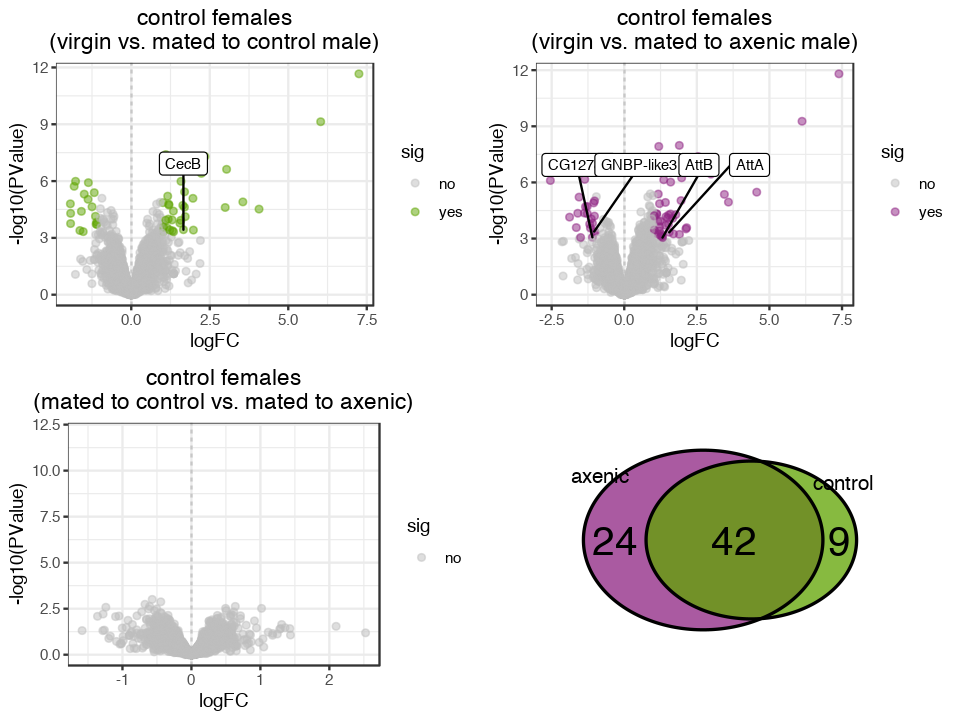

In [57]:
options(repr.plot.width = 8, repr.plot.height =6)
# pdf("Results/Figures/mated_control_female_contrasts_panel.pdf", width = 8, height = 6)
plot_grid(CC.v.C_contrasts_volcano.gg, CA.v.C_contrasts_volcano.gg, CC.v.CA_contrasts_volcano.gg, myVennn, ncol = 2, nrow = 2, scale = c(1, 1, 1, 0.6))
# dev.off()

Check for enriched GO terms:

Make a factor object with elements of the above venn diagram:

In [58]:
matedControlFemale.factors = as.data.frame(unlist(CCxC.v.CAxC.v.CCxCA_elements))
matedControlFemale.factors$cat = rownames(matedControlFemale.factors)
matedControlFemale.factors$cat = gsub("[[:digit:]]", "", matedControlFemale.factors$cat)
colnames(matedControlFemale.factors) = c("FBgn_ID", "category")
rownames(matedControlFemale.factors) = matedControlFemale.factors$FBgn_ID
matedControlFemale.factors = subset(matedControlFemale.factors, select = "category")
matedControlFemale.factors$category = gsub(",", "_", matedControlFemale.factors$category)
matedControlFemale.factor_list = unique(matedControlFemale.factors[,1])

Output individual gene plots for each category of the venn diagram:

In [59]:
# for (feature_cat in matedControlFemale.factor_list) {
#     tmp.Plots = suppressMessages(lapply(rownames(matedControlFemale.factors)[matedControlFemale.factors$category == feature_cat], geneBarPlot_mon_byFemale, tpmTable = tpm.table.rc, female = "control", show_reps = T))
#     ggsave(paste("Results/Figures/single_gene_plots/matedControlFemale.", feature_cat, ".pdf", sep = ""), marrangeGrob(grobs = tmp.Plots, nrow = 2, ncol =2))
# }


Output a gene snapshot table:

In [60]:
matedControlFemale_gene_snapshots_list = list()
for (feature_cat in matedControlFemale.factor_list) {
    tmpInfo = filter(snapshots, FBgn_ID %in% rownames(matedControlFemale.factors)[matedControlFemale.factors$category == feature_cat])
    tmpInfo = select(tmpInfo, -datestamp)
    category = feature_cat
    tmpInfo$category = category
    matedControlFemale_gene_snapshots_list[[feature_cat]] = tmpInfo
}
matedControlFemale_gene_snapshots = rbindlist(matedControlFemale_gene_snapshots_list)
# write.table(matedControlFemale_gene_snapshots, "Results/Tables/matedControlFemale_sigGenes_snapshots.txt", quote = F, sep = "\t", row.names = F)
rm(matedControlFemale_gene_snapshots_list)

### Contrast between virgin and mated axenic females:

Set up the contrasts:

In [61]:
AA.v.A_contrasts <- makeContrasts(AA-A, levels=design_2)
AC.v.A_contrasts <- makeContrasts(AC-A, levels=design_2)

Now compare the mated axenic females to virgin axenic females. First, females mated to axenic males

In [62]:
# run the LRT and extract the DE table
lrt.AA.v.A.table <- edge.DE(dgeList_fit, AA.v.A_contrasts, LRT = F)

AA.v.A_sigGenes = subset(lrt.AA.v.A.table, sig == "yes")$gene
AA.v.A_sigGenes_up = subset(lrt.AA.v.A.table, sig == "yes" & logFC > 1)$gene
AA.v.A_sigGenes_down = subset(lrt.AA.v.A.table, sig == "yes" & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AA.v.A_contrasts_volcano.gg = edge.DE.gg(lrt.AA.v.A.table) +
                                scale_colour_manual(values = c("grey","#ffad35")) +
                                geom_label_repel(data = filter(lrt.AA.v.A.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3,
                                colour = "#7a5100",
#                                 ylim = c(6, NA),
                                               ) +
                                labs(title = "axenic females\n(virgin vs. mated to axenic male)", size = 2) +
#                                 theme_black_full() +
                                theme(axis.text.x = element_text(angle = 0), plot.title = element_text(hjust = 0.5))
                                

... and females mated to control males

In [63]:
# run the LRT and extract the DE table
lrt.AC.v.A.table <- edge.DE(dgeList_fit, AC.v.A_contrasts, LRT = F)

AC.v.A_sigGenes = subset(lrt.AC.v.A.table, sig == "yes")$gene
AC.v.A_sigGenes_up = subset(lrt.AC.v.A.table, sig == "yes" & logFC > 1)$gene
AC.v.A_sigGenes_down = subset(lrt.AC.v.A.table, sig == "yes" & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AC.v.A_contrasts_volcano.gg = edge.DE.gg(lrt.AC.v.A.table) +
                                scale_colour_manual(values = c("grey","#255488")) +
                                geom_label_repel(data = filter(lrt.AC.v.A.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 30,
                                fontface = "bold", 
                                size = 3,
#                                 ylim = c(6, NA),
                                colour = "#7a5100") +
                                labs(title = "axenic females\n(virgin vs. mated to control male)", size = 2) +
#                                 theme_black_full() +
                                theme(axis.text.x = element_text(angle = 0), plot.title = element_text(hjust = 0.5))

Let's directly compare DE between the AC and AA samples. First set up the contrast:

In [64]:
AC.v.AA_contrasts <- makeContrasts(AC-AA, levels=design_2)

Now perform the test:

In [65]:
# run the LRT and extract the DE table
lrt.AC.v.AA.table <- edge.DE(dgeList_fit, AC.v.AA_contrasts, LRT = F)

AC.v.AA_sigGenes = subset(lrt.AC.v.AA.table, sig == "yes")$gene
AC.v.AA_sigGenes_up = subset(lrt.AC.v.AA.table, sig == "yes" & logFC > 1)$gene
AC.v.AA_sigGenes_down = subset(lrt.AC.v.AA.table, sig == "yes" & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3)
AC.v.AA_contrasts_volcano.gg = edge.DE.gg(lrt.AC.v.AA.table) +
                                scale_colour_manual(values = c("grey","#982b1e")) +
                                geom_label_repel(data = filter(lrt.AC.v.AA.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 30,
                                fontface = "bold", 
                                size = 3,
#                                 ylim = c(6, NA),
                                colour = "#006294") +
                                labs(title = "axenic females\n(mated to control vs. mated to axenic)", size = 2) +
#                                 theme_black_full() +
                                theme(axis.text.x = element_text(angle = 0), plot.title = element_text(hjust = 0.5))

We can now directly look at the overlap between the three contrasts:

In [66]:
AAxA.v.ACxA.v.ACxAA_candidates <- list(axenic = AA.v.A_sigGenes, 
                        control = AC.v.A_sigGenes,
                                between = AC.v.AA_sigGenes)

AAxA.v.ACxA.v.ACxAA_Vdiag<-venn.diagram(AAxA.v.ACxA.v.ACxAA_candidates, NULL, fill=c("#ffad35","#006294","#982b1e"), alpha=c(0.75,0.75, 0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

AAxA.v.ACxA.v.ACxAA_combs <- unlist(lapply(1:length(AAxA.v.ACxA.v.ACxAA_candidates), function(j) combn(names(AAxA.v.ACxA.v.ACxAA_candidates), j, simplify = FALSE)), recursive = FALSE)
names(AAxA.v.ACxA.v.ACxAA_combs) <- sapply(AAxA.v.ACxA.v.ACxAA_combs, function(i) paste0(i, collapse = ","))
AAxA.v.ACxA.v.ACxAA_elements <- lapply(AAxA.v.ACxA.v.ACxAA_combs, function(i) Setdiff(AAxA.v.ACxA.v.ACxAA_candidates[i], AAxA.v.ACxA.v.ACxAA_candidates[setdiff(names(AAxA.v.ACxA.v.ACxAA_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
# grid.arrange(gTree(children=AAxA.v.ACxA.v.ACxAA_Vdiag))
    myVennn = arrangeGrob(gTree(children=AAxA.v.ACxA.v.ACxAA_Vdiag))
summary(AAxA.v.ACxA.v.ACxAA_elements)
rm(AAxA.v.ACxA.v.ACxAA_candidates, AAxA.v.ACxA.v.ACxAA_Vdiag, AAxA.v.ACxA.v.ACxAA_combs)

                       Length Class  Mode     
axenic                 67     -none- character
control                31     -none- character
between                95     -none- character
axenic,control         45     -none- character
axenic,between         19     -none- character
control,between        18     -none- character
axenic,control,between  4     -none- character

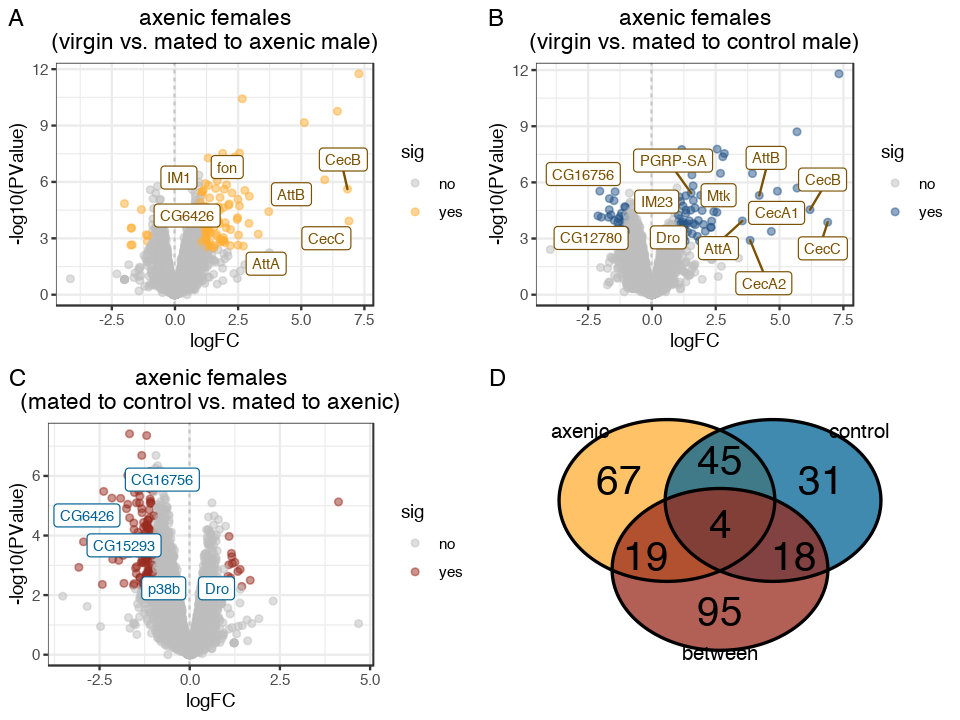

In [67]:
options(repr.plot.width = 8, repr.plot.height =6)
# pdf("Results/Figures/mated_axenic_female_contrasts_panel.pdf", width = 8, height = 6)
plot_grid(AA.v.A_contrasts_volcano.gg, AC.v.A_contrasts_volcano.gg, AC.v.AA_contrasts_volcano.gg, myVennn, ncol = 2, nrow = 2, scale = c(1, 1, 1, 0.7), labels = c("A", "B", "C", "D"))
# dev.off()

Make a factor object with elements of the above venn diagram:

In [69]:
matedAxenicFemale.factors = as.data.frame(unlist(AAxA.v.ACxA.v.ACxAA_elements))
matedAxenicFemale.factors$cat = rownames(matedAxenicFemale.factors)
matedAxenicFemale.factors$cat = gsub("[[:digit:]]", "", matedAxenicFemale.factors$cat)
colnames(matedAxenicFemale.factors) = c("FBgn_ID", "category")
rownames(matedAxenicFemale.factors) = matedAxenicFemale.factors$FBgn_ID
matedAxenicFemale.factors = subset(matedAxenicFemale.factors, select = "category")
matedAxenicFemale.factors$category = gsub(",", "_", matedAxenicFemale.factors$category)
matedAxenicFemale.factor_list = unique(matedAxenicFemale.factors[,1])

Output individual gene plots for each category of the venn diagram:

In [70]:
for (feature_cat in matedAxenicFemale.factor_list) {
    tmp.Plots = suppressMessages(lapply(rownames(matedAxenicFemale.factors)[matedAxenicFemale.factors$category == feature_cat], geneBarPlot_mon_byFemale, tpmTable = tpm.table.rc, female = "axenic", show_reps = T))
#     ggsave(paste("Results/Figures/single_gene_plots/matedAxenicFemale.", feature_cat, ".pdf", sep = ""), marrangeGrob(grobs = tmp.Plots, nrow = 2, ncol =2))
}


Output a gene snapshot table:

In [71]:
matedAxenicFemale_gene_snapshots_list = list()
for (feature_cat in matedAxenicFemale.factor_list) {
    tmpInfo = filter(snapshots, FBgn_ID %in% rownames(matedAxenicFemale.factors)[matedAxenicFemale.factors$category == feature_cat])
    tmpInfo = select(tmpInfo, -datestamp)
    category = feature_cat
    tmpInfo$category = category
    matedAxenicFemale_gene_snapshots_list[[feature_cat]] = tmpInfo
}
matedAxenicFemale_gene_snapshots = rbindlist(matedAxenicFemale_gene_snapshots_list)
# write.table(matedAxenicFemale_gene_snapshots, "Results/Tables/matedAxenicFemale_sigGenes_snapshots.txt", quote = F, sep = "\t", row.names = F)
rm(matedAxenicFemale_gene_snapshots_list)

Check the overlap between the mating response genes:

                    Length Class  Mode     
CaCo                19     -none- character
CcCo                 4     -none- character
AaAo                82     -none- character
AcAo                41     -none- character
CaCo,CcCo           12     -none- character
CaCo,AaAo            0     -none- character
CaCo,AcAo            1     -none- character
CcCo,AaAo            2     -none- character
CcCo,AcAo            1     -none- character
AaAo,AcAo           21     -none- character
CaCo,CcCo,AaAo       2     -none- character
CaCo,CcCo,AcAo       6     -none- character
CaCo,AaAo,AcAo       4     -none- character
CcCo,AaAo,AcAo       2     -none- character
CaCo,CcCo,AaAo,AcAo 22     -none- character

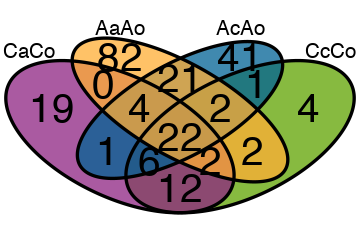

In [72]:
tempo_candidates <- list(CaCo = CA.v.C_sigGenes, 
                        CcCo = CC.v.C_sigGenes,
                        AaAo = AA.v.A_sigGenes, 
                        AcAo = AC.v.A_sigGenes)

tempo_Vdiag<-venn.diagram(tempo_candidates, NULL, fill=c("#8e2381","#5fa300","#ffad35","#006294"), alpha=c(0.75, 0.75, 0.75, 0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

tempo_combs <- unlist(lapply(1:length(tempo_candidates), function(j) combn(names(tempo_candidates), j, simplify = FALSE)), recursive = FALSE)
names(tempo_combs) <- sapply(tempo_combs, function(i) paste0(i, collapse = ","))
tempo_elements <- lapply(tempo_combs, function(i) Setdiff(tempo_candidates[i], tempo_candidates[setdiff(names(tempo_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
grid.arrange(gTree(children=tempo_Vdiag))
    myVennn = arrangeGrob(gTree(children=tempo_Vdiag))
summary(tempo_elements)
# rm(tempo_candidates, tempo_Vdiag, tempo_combs)

### Virgin female contrasts (axenic vs. control):

First we'll set up the contrast:

In [73]:
# pairwise contrasts
virgin_contrasts <- makeContrasts(C-A, levels=design_2)

Now look at the difference between the axenic and control virgin samples:

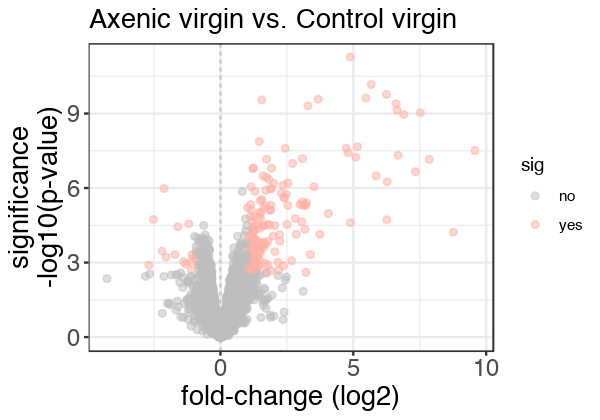

In [74]:
# run the LRT and extract the DE table
lrt.virgins.table <- edge.DE(dgeList_fit, virgin_contrasts, LRT = F)

virgins_sigGenes = subset(lrt.virgins.table, sig == "yes")$gene
virgins_sigGenes_up = subset(lrt.virgins.table, sig == "yes" & logFC > 1)$gene
virgins_sigGenes_down = subset(lrt.virgins.table, sig == "yes" & logFC < -1)$gene

options(repr.plot.width = 5, repr.plot.height = 3.5)
# pdf("Results/Figures/virgin_female_contrast_volcanoPlot.pdf", width = 5, height = 3.5)
(virgin_contrasts_volcano.gg = edge.DE.gg(lrt.virgins.table) +
                                scale_colour_manual(values = c("grey", "#feb0a4")) +
#                                 geom_label_repel(data = filter(lrt.virgins.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
#                                 force = 30,
#                                 colour = "#4d5806",
#                                 fontface = "bold", 
# #                                 size = 3,
# #                                 xlim = c(NA, 5),
# #                                 ylim = c(6.5, NA),
#                                                 ) +
                                labs(x = "fold-change (log2)", y = "significance\n-log10(p-value)") +
                                labs(title = "Axenic virgin vs. Control virgin", size = 2) +
#                                 theme_monokai_full() + 
                                theme(axis.text = element_text(angle = 0, size = 14),
                                     axis.title = element_text(size = 16),
                                     plot.title = element_text(size = 16)))
ggsave("Results/manuscript_figures/virgin_contrasts_volcanoPlot.pdf", width = 5, height = 3.5)

Look at a heatmap of these results, partciularly the immunity genes:

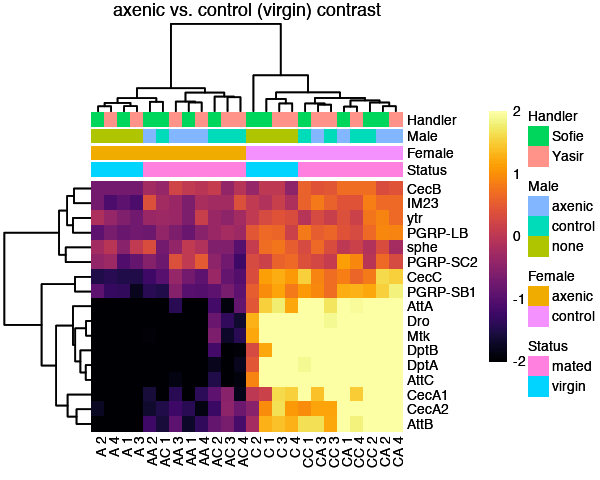

In [75]:
options(repr.plot.width = 5, repr.plot.height = 4)
heatmap_fa2(tpm_bt2_fixed, subset(immunity_genes.df, FlyBaseID %in% virgins_sigGenes)$FlyBaseID, fly_atlas = F, title = "axenic vs. control (virgin) contrast")

These plots show that many DE genes are immune-related. We can list those here:

In [76]:
subset(immunity_genes.df, FlyBaseID %in% virgins_sigGenes)

,FlyBaseID,Symbol,Name,Synonyms,Chr,Cyto,Functional Class,Notes
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
7,FBgn0012042,AttA,Attacin-A,.,2R,51C1,effector,antimicrobial peptide
8,FBgn0041581,AttB,Attacin-B,.,2R,51C1,effector,antimicrobial peptide
9,FBgn0041579,AttC,Attacin-C,.,2R,50A3,effector,antimicrobial peptide
19,FBgn0000276,CecA1,Cecropin A1,.,3R,99E2,effector,antimicrobial peptide
20,FBgn0000277,CecA2,Cecropin A2,.,3R,99E2,effector,antimicrobial peptide
21,FBgn0000278,CecB,Cecropin B,.,3R,99E2,effector,antimicrobial peptide
22,FBgn0000279,CecC,Cecropin C,.,3R,99E2,effector,antimicrobial peptide
54,FBgn0030774,CG9675,.,spheroide,X,15A1--2,signaling,protease
69,FBgn0004240,Dpt,Diptericin,.,2R,55F8,effector,antimicrobial peptide


Now pull out the DE gene set between axenic and control (and the background set)

In [77]:
as_tibble(lrt.virgins.table) %>% 
    filter(sig == "yes") %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> virSig_entrezId

as_tibble(lrt.virgins.table) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> all_entrezId

Warning message:
"Column `FBgn_ID` joining character vector and factor, coercing into character vector"
Warning message:
"Column `FBgn_ID` joining character vector and factor, coercing into character vector"


Now perform GO enrichment analysis and create a custom dotplot

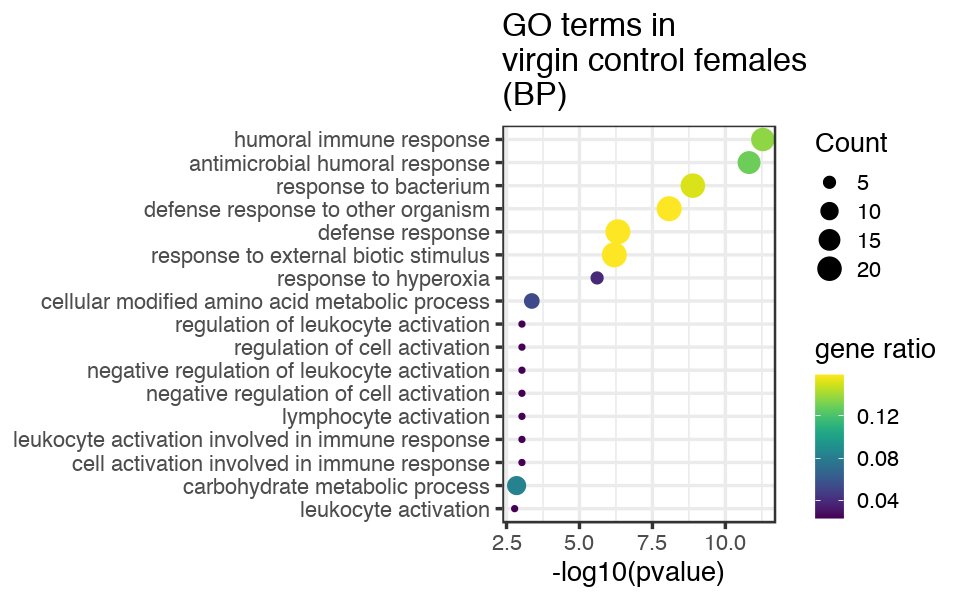

In [82]:
ego <- enrichGO(gene          = virSig_entrezId,
                universe      = all_entrezId,
                OrgDb         = org.Dm.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.05,
                minGSSize = 2,
                readable      = TRUE)

myEGO <- as.data.frame(gofilter(ego, level = 4))
myEGO$DEset = as.numeric(gsub(".*\\/", "", myEGO$GeneRatio))
myEGO$`gene ratio` = myEGO$Count/myEGO$DEset

options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(myEGO, aes(reorder(Description, -pvalue), -log10(pvalue), colour = `gene ratio`, size = Count)) +    geom_point() +
 coord_flip() +
scale_colour_viridis() +
theme(axis.title.y = element_blank()) +
labs(title = "GO terms in \nvirgin control females\n(BP)")

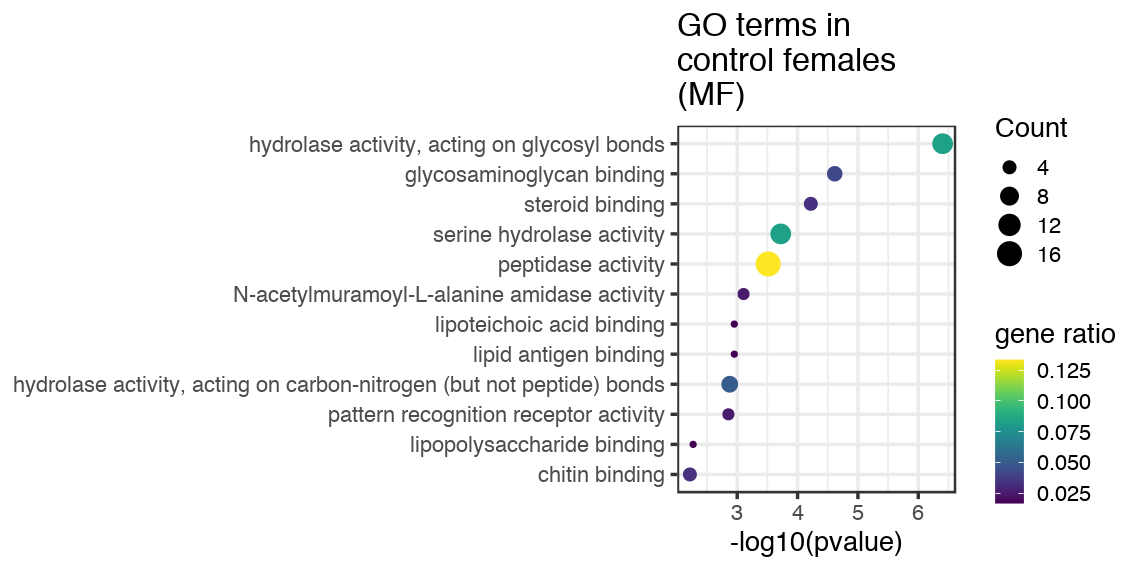

In [83]:
ego <- enrichGO(gene          = virSig_entrezId,
                universe      = all_entrezId,
                OrgDb         = org.Dm.eg.db,
                ont           = "MF",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.05,
                minGSSize = 2,
                readable      = TRUE)

myEGO <- as.data.frame(gofilter(ego, level = 4))
myEGO$DEset = as.numeric(gsub(".*\\/", "", myEGO$GeneRatio))
myEGO$`gene ratio` = myEGO$Count/myEGO$DEset

options(repr.plot.width = 9.5, repr.plot.height = 4.75)
ggplot(myEGO, aes(reorder(Description, -pvalue), -log10(pvalue), colour = `gene ratio`, size = Count)) +    geom_point() +
 coord_flip() +
scale_colour_viridis() +
theme(axis.title.y = element_blank()) +
labs(title = "GO terms in \ncontrol females\n(MF)")

And also KEGG pathways:

In [84]:
virgins_sigGenes_altIDs = subset(annotation, primary_FBgn %in% virgins_sigGenes & !is.na(annotation_ID))
virgins_sigGenes_altIDs = paste(virgins_sigGenes_altIDs$organism_abbreviation, virgins_sigGenes_altIDs$annotation_ID, sep = "_")
virgins_kegg <- enrichKEGG(gene = virgins_sigGenes_altIDs, organism = 'dme')
subset(virgins_kegg@result, qvalue < 0.05)
# write.table(virgins_kegg@result, "Results/Tables/virgins_sigGenes_KEGG_enirchment.txt", quote = F, sep = "\t", row.names = F)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
dme04624,dme04624,Toll and Imd signaling pathway,10/48,81/3231,1.687063e-07,4.006306e-06,2.720751e-06,Dmel_CG10794/Dmel_CG12763/Dmel_CG14704/Dmel_CG9681/Dmel_CG1373/Dmel_CG1365/Dmel_CG1367/Dmel_CG1878/Dmel_CG14745/Dmel_CG9675,10
dme00500,dme00500,Starch and sucrose metabolism,7/48,32/3231,2.584714e-07,4.006306e-06,2.720751e-06,Dmel_CG8221/Dmel_CG8694/Dmel_CG8690/Dmel_CG8693/Dmel_CG8695/Dmel_CG8696/Dmel_CG11669,7
dme00052,dme00052,Galactose metabolism,6/48,36/3231,1.085052e-05,1.121221e-04,7.614401e-05,Dmel_CG8694/Dmel_CG8690/Dmel_CG8693/Dmel_CG8695/Dmel_CG8696/Dmel_CG11669,6
dme04142,dme04142,Lysosome,9/48,119/3231,4.599629e-05,3.564713e-04,2.420857e-04,Dmel_CG11315/Dmel_CG9463/Dmel_CG9468/Dmel_CG9494/Dmel_CG31410/Dmel_CG12602/Dmel_CG11314/Dmel_CG8823/Dmel_CG31148,9
dme00511,dme00511,Other glycan degradation,3/48,22/3231,3.887334e-03,2.410147e-02,1.636772e-02,Dmel_CG9463/Dmel_CG9468/Dmel_CG31148,3
dme00480,dme00480,Glutathione metabolism,5/48,79/3231,5.786748e-03,2.989820e-02,2.030438e-02,Dmel_CG31233/Dmel_CG4421/Dmel_CG4181/Dmel_CG17524/Dmel_CG8721,5
dme00600,dme00600,Sphingolipid metabolism,3/48,28/3231,7.769138e-03,3.440618e-02,2.336583e-02,Dmel_CG11425/Dmel_CG3576/Dmel_CG31148,3
dme00983,dme00983,Drug metabolism - other enzymes,5/48,97/3231,1.355641e-02,5.253109e-02,3.567476e-02,Dmel_CG4421/Dmel_CG4181/Dmel_CG17524/Dmel_CG8353/Dmel_CG6633,5
dme00982,dme00982,Drug metabolism - cytochrome P450,4/48,68/3231,1.741895e-02,5.670665e-02,3.851046e-02,Dmel_CG4421/Dmel_CG4181/Dmel_CG17524/Dmel_CG6633,4


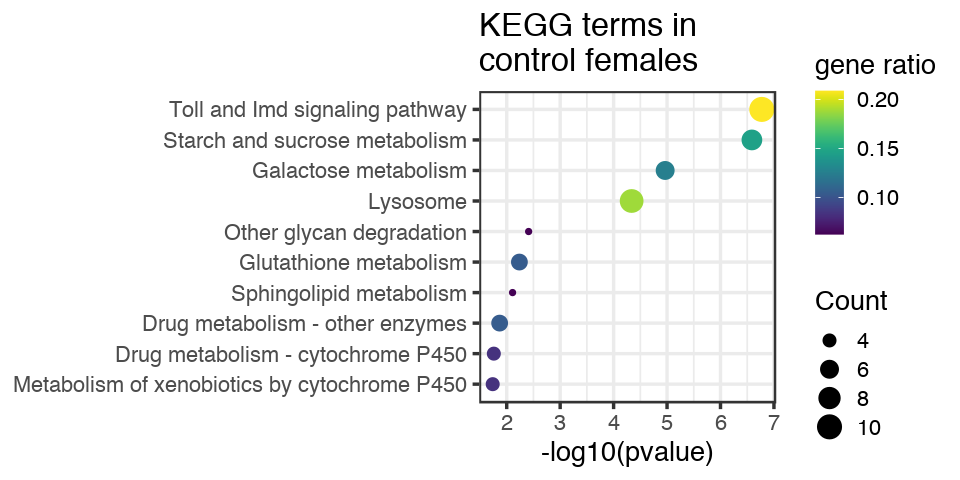

In [85]:
myKEGG <- as.data.frame(filter(virgins_kegg@result, qvalue < 0.05))
myKEGG$DEset = as.numeric(gsub(".*\\/", "", myKEGG$GeneRatio))
myKEGG$`gene ratio` = myKEGG$Count/myKEGG$DEset

options(repr.plot.width = 8, repr.plot.height = 4)
ggplot(myKEGG, aes(reorder(Description, -pvalue), -log10(pvalue),colour = `gene ratio`, size  = Count)) +    geom_point() +
 coord_flip() +
scale_colour_viridis() +
theme(axis.title.y = element_blank()) +
labs(title = "KEGG terms in\ncontrol females")

Do the Gene set enrichment analysis (GSEA), in'it?

In [86]:
as_tibble(lrt.virgins.table) %>% 
#     filter(sig == "yes" & logFC > 1) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    select(ent_id, logFC) %>% 
#     unique() %>% 
    arrange(desc(logFC)) %>% 
    deframe() ->
    geneList

geneList <- geneList[!duplicated(geneList)]
# head(geneList[!duplicated(geneList)])

Warning message:
"Column `FBgn_ID` joining character vector and factor, coercing into character vector"


In [87]:
virgins.gsea <- gseGO(geneList     = geneList,
              OrgDb        = org.Dm.eg.db,
              ont          = "MF",
              nPerm        = 100000,
              minGSSize    = 50,
              maxGSSize    = 500,
              pvalueCutoff = 0.05,
              verbose      = TRUE)
as_tibble(virgins.gsea)

preparing geneSet collections...

GSEA analysis...

Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
"There are duplicate gene names, fgsea may produce unexpected results"
leading edge analysis...

done...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0004553,"hydrolase activity, hydrolyzing O-glycosyl compounds",60,0.6924859,2.004464,5.105101e-05,0.005884942,0.005519615,588,"tags=28%, list=8%, signal=26%",42796/34206/35827/35826/36863/34203/35829/38125/35825/34205/35824/246565/35830/38122/46813/49815/34598
GO:0016798,"hydrolase activity, acting on glycosyl bonds",65,0.6745563,1.974618,7.544797e-05,0.005884942,0.005519615,397,"tags=23%, list=5%, signal=22%",42796/34206/35827/35826/36863/34203/35829/38125/35825/34205/35824/246565/35830/38122/46813


Plot those results:

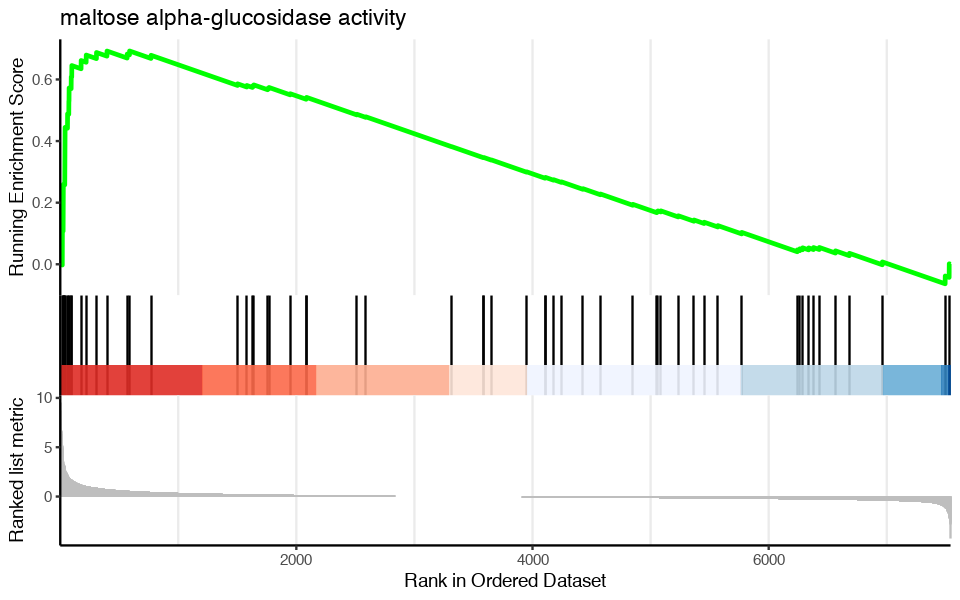

In [89]:
options(repr.plot.width = 8, repr.plot.height = 5)
gseaplot2(virgins.gsea, geneSetID = 1, title = ego$Description[1])

** from Sofie's code **

In [77]:
# d <- read.delim("Sofie_RUVseq/ClusterProfiler/RUVr_maleA.txt", header=T, as.is=T) # this file contains all genes in the filtered dataset
# d <- cbind(rownames(d), d)
# rownames(d) <- NULL
# d <- d[,c(1,2)]

as_tibble(lrt.virgins.table) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    select(FBID = FBgn_ID, logFC) -> d

# map the genes in the dataset to their entrez IDs
genes <- d[,1]
gene_entrez <- z[which(z %in% genes)] # 7638; 11 genes are missing, will add those manually
extra <- c(setdiff(rownames(d), gene_entrez))
names(extra) <- c("34877", "38740", "36952", "41518", "39480", "31605", "41192", "32592", 
                  "35554", "41058", "38391")
gene_entrez_full <- c(gene_entrez, extra)

# object with the DE genes for this contrast
dat <- read.delim("Sofie_RUVseq/ClusterProfiler/RUVr_maleA.txt", header=T, as.is=T)
DE <- dat[dat$FDR<0.05 & abs(dat$logFC)>1,]
gene <- rownames(DE)
gene_DE <- gene_entrez_full[which(gene_entrez_full %in% gene)]

# Make a geneList for the GSEA 
colnames(d) <- c("FBID", "logFC")
temp.dat <- cbind(names(gene_entrez_full), gene_entrez_full)
rownames(temp.dat) <- NULL
colnames(temp.dat) <- c("entrez", "FBID")
temp.dat <- as.data.frame(temp.dat)
test <-  merge(temp.dat, d, by ="FBID", all=T)
head(test)
tail(test)
# numeric vector for geneList:
geneList = test[,3]
# named vector for geneList:
names(geneList) = as.character(test[,2])
# decreasing order:
geneList = sort(geneList, decreasing = T)

Warning message:
"Column `FBgn_ID` joining character vector and factor, coercing into character vector"


ERROR: Error in eval(expr, envir, enclos): object 'z' not found


Output all individual gene plots for the virgin contrasts:

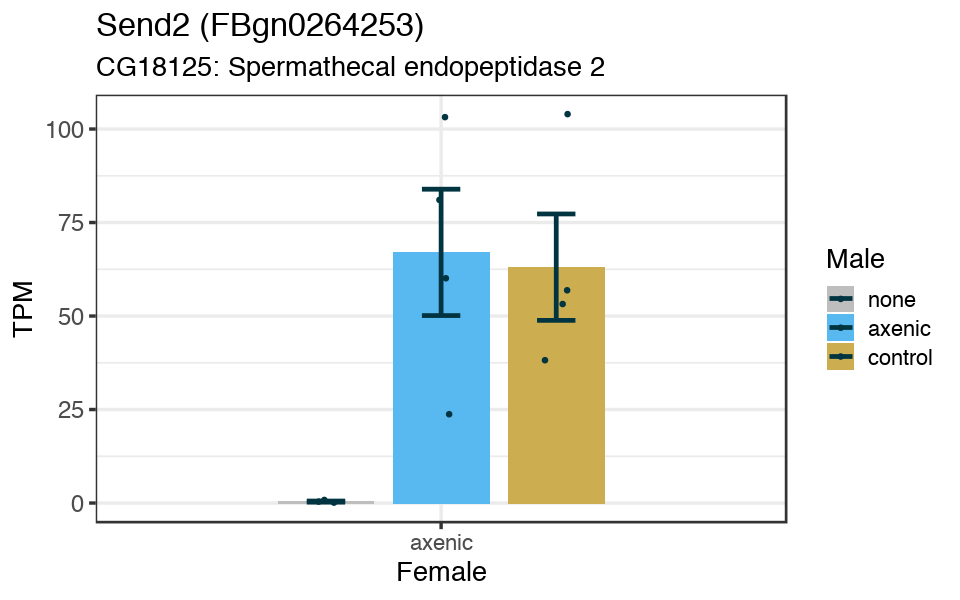

In [99]:
geneBarPlot_byFemale(tpm.table, "Send2", show_reps = T)

In [46]:
virgins_sigGenes.Plots = suppressMessages(lapply(virgins_sigGenes, geneBarPlot_mon, tpmTable = tpm.table.rc, show_reps = F))
ggsave("Results/Figures/virgins_sigGenes.barPlots.pdf", marrangeGrob(grobs = virgins_sigGenes.Plots, nrow = 2, ncol =2))

Saving 7 x 7 in image


And output snapshot summary:

In [47]:
tempInfo = filter(snapshots, FBgn_ID %in% virgins_sigGenes)
tempInfo = select(tempInfo, -datestamp)
write.table(tempInfo, "Results/Tables/virgins_sigGenes_snapshots.txt", quote = F, sep = "\t", row.names = F)
rm(tempInfo)

### Comparing axenic and control mated females:

In [100]:
mated.contrast <- makeContrasts(((CA+CC)/2) - ((AA+AC)/2), levels = design_2)

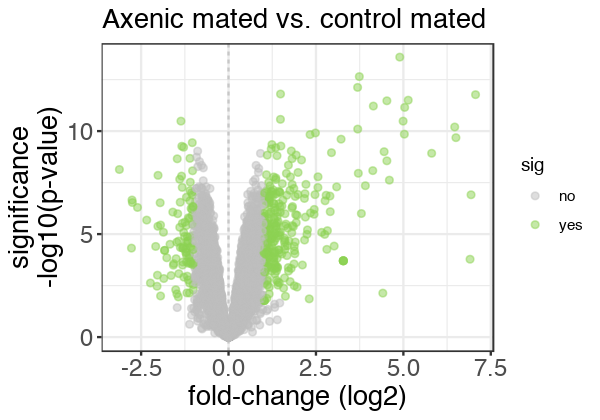

In [101]:
options(repr.plot.width = 5, repr.plot.height = 3.5)
lrt.mated.table <- edge.DE(dgeList_fit,mated.contrast, LRT = F)
# lrt.mated.table <- filter(lrt.mated.table, gene %!in% virgins_sigGenes)

mated_sigGenes = subset(lrt.mated.table, sig == "yes")$gene
mated_sigGenes_up = subset(lrt.mated.table, sig == "yes" & logFC > 1)$gene
mated_sigGenes_down = subset(lrt.mated.table, sig == "yes" & logFC < -1)$gene

edge.DE.gg(lrt.mated.table) +
                                scale_colour_manual(values = c("grey", "#8cd253")) +
#                                 geom_text_repel(data = filter(lrt.mated.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
#                                 force = 30,
#                                 colour = "green",
#                                 fontface = "bold", 
#                                 size = 3,
#                                 ylim = c(5, NA)) +
                                labs(x = "fold-change (log2)", y = "significance\n-log10(p-value)") +
                                labs(title = "Axenic mated vs. control mated") +
                                theme(axis.text = element_text(angle = 0, size = 14),
                                     axis.title = element_text(size = 16),
                                     plot.title = element_text(size = 16))
ggsave("Results/manuscript_figures/mated_contrasts_volcanoPlot.pdf", width = 5, height = 3.5)

Check the overlap between the significant genes in the virgin contrasts and in the mated contrasts:

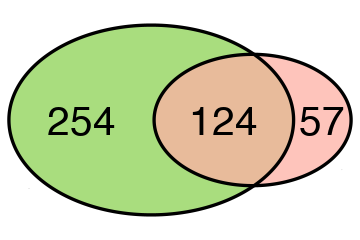

In [102]:
tempo_candidates <- list(virgin = virgins_sigGenes, 
                        mated = mated_sigGenes)

tempo_Vdiag<-venn.diagram(tempo_candidates, NULL, fill=c("#feb0a4","#8cd253"), alpha=c(0.75, 0.75), cex = 2, cat.fontface= 1, cat.cex = 0, resolution = 100, )

tempo_combs <- unlist(lapply(1:length(tempo_candidates), function(j) combn(names(tempo_candidates), j, simplify = FALSE)), recursive = FALSE)
names(tempo_combs) <- sapply(tempo_combs, function(i) paste0(i, collapse = ","))
tempo_elements <- lapply(tempo_combs, function(i) Setdiff(tempo_candidates[i], tempo_candidates[setdiff(names(tempo_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
grid.arrange(gTree(children=tempo_Vdiag))
    myVennn = arrangeGrob(gTree(children=tempo_Vdiag))
# summary(tempo_elements)
# rm(tempo_candidates, tempo_Vdiag, tempo_combs)

In [93]:
head(tpm.matrix_fa2.female_tissues)
FlyAtlas_DE <- tpm.matrix_fa2.female_tissues[rownames(tpm.matrix_fa2.female_tissues) %in% tempo_elements$mated,]
Enrichment_DE <- apply(FlyAtlas_DE, 1, function(x) x/sum(x))
Enrichment_DE[is.infinite(Enrichment_DE)]<-NA

,Female_Anal_Pad,Female_Crop,Female_Salivary_Gland,Female_Midgut,Female_Hindgut,Female_Tubule,Female_Brain,Female_Eye,Female_Head,Female_Thoracicoabdominal_Ganglion,Female_Virgin_Spermatheca,Female_Mated_Spermatheca,Ovary,Female_Carcass
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FBgn0000003,73738.266895,8.050788e+04,4.356584e+04,6.041499e+04,39896.588446,7.705861e+04,7.590068e+04,3.317265e+04,1.408642e+05,40303.923250,23665.598526,20946.126799,6.563629e+04,5.469290e+04
FBgn0000008,3.165010,3.081657e+00,2.346348e+00,6.800639e-01,2.619771,2.728298e+00,1.917717e+01,1.130504e+01,5.280976e+00,6.169856,31.597805,26.275625,1.908223e+01,5.978080e+00
FBgn0000014,1.131035,2.953916e-01,1.212081e-01,5.076735e-01,0.722665,1.500415e-01,2.619245e-02,2.014449e-02,0.000000e+00,6.608428,65.411361,64.121891,2.298884e+00,3.937150e+00
FBgn0000015,8.056285,4.973189e-02,0.000000e+00,0.000000e+00,4.180449,2.638050e-01,4.629580e-02,5.895166e-03,0.000000e+00,1.803700,15.784867,15.160303,1.021826e-01,5.373691e-01
FBgn0000017,5.338163,4.039734e+00,4.291695e+00,9.308114e-01,4.276795,3.678037e+00,2.665580e+01,1.007872e+01,9.494248e+00,18.479202,5.343087,4.656305,1.691735e+01,2.570448e+00
FBgn0000018,8.583274,1.018293e+01,5.876023e+00,5.873226e+00,9.508907,9.966953e+00,7.148821e+00,8.387761e+00,5.932221e+00,7.488062,3.065310,3.499297,3.253029e+01,9.824024e+00


In [95]:
test<- cbind(rownames(Enrichment_DE), Enrichment_DE)
rownames(test) <- NULL
colnames(test) <- c("Tissue", colnames(Enrichment_DE))
test <- as.data.frame(test)
colnames(test)
data_long <- gather(test, Gene, Enrichment,
                    colnames(test)[2]:colnames(test)[length(colnames(test))], 
                    factor_key=TRUE)
data_long$Tissue<- factor(data_long$Tissue, levels = unique(data_long$Tissue))


[1] "Tissue"      "FBgn0000044" "FBgn0000047" "FBgn0000183" "FBgn0000241"
  [6] "FBgn0000308" "FBgn0001108" "FBgn0001941" "FBgn0001992" "FBgn0002022"
 [11] "FBgn0002524" "FBgn0002868" "FBgn0002921" "FBgn0002936" "FBgn0002938"
 [16] "FBgn0003089" "FBgn0003277" "FBgn0003357" "FBgn0003475" "FBgn0003654"
 [21] "FBgn0003744" "FBgn0003861" "FBgn0004374" "FBgn0004428" "FBgn0004507"
 [26] "FBgn0004580" "FBgn0004636" "FBgn0004687" "FBgn0004924" "FBgn0005670"
 [31] "FBgn0010041" "FBgn0010246" "FBgn0010358" "FBgn0010385" "FBgn0010397"
 [36] "FBgn0010602" "FBgn0011217" "FBgn0011481" "FBgn0011693" "FBgn0013276"
 [41] "FBgn0013348" "FBgn0013673" "FBgn0013685" "FBgn0014019" "FBgn0014020"
 [46] "FBgn0014133" "FBgn0015799" "FBgn0016672" "FBgn0016984" "FBgn0017550"
 [51] "FBgn0019643" "FBgn0019968" "FBgn0020255" "FBgn0020412" "FBgn0020508"
 [56] "FBgn0020622" "FBgn0022355" "FBgn0023178" "FBgn0025393" "FBgn0026370"
 [61] "FBgn0027334" "FBgn0027548" "FBgn0027929" "FBgn0028408" "FBgn0028415"
 [66] "FBgn0028416" "FBgn0028491" "FBgn0028534" "FBgn0028537" "FBgn0028945"
 [71] "FBgn0028949" "FBgn0029006" "FBgn0029696" "FBgn0029913" "FBgn0030041"
 [76] "FBgn0030103" "FBgn0030237" "FBgn0030258" "FBgn0030274" "FBgn0030432"
 [81] "FBgn0030529" "FBgn0030628" "FBgn0030643" "FBgn0030672" "FBgn0030777"
 [86] "FBgn0031248" "FBgn0031249" "FBgn0031327" "FBgn0031533" "FBgn0031534"
 [91] "FBgn0031630" "FBgn0031689" "FBgn0031692" "FBgn0031740" "FBgn0031821"
 [96] "FBgn0031882" "FBgn0031942" "FBgn0032068" "FBgn0032280" "FBgn0032299"
[101] "FBgn0032431" "FBgn0032774" "FBgn0032788" "FBgn0033027" "FBgn0033215"
[106] "FBgn0033216" "FBgn0033268" "FBgn0033327" "FBgn0033357" "FBgn0033374"
[111] "FBgn0033423" "FBgn0033437" "FBgn0033481" "FBgn0033518" "FBgn0033602"
[116] "FBgn0033775" "FBgn0033844" "FBgn0033904" "FBgn0034045" "FBgn0034103"
[121] "FBgn0034245" "FBgn0034402" "FBgn0034474" "FBgn0034507" "FBgn0034509"
[126] "FBgn0034515" "FBgn0034565" "FBgn0035035" "FBgn0035153" "FBgn0035357"
[131] "FBgn0035407" "FBgn0035656" "FBgn0035674" "FBgn0035689" "FBgn0035692"
[136] "FBgn0035806" "FBgn0035886" "FBgn0035926" "FBgn0035983" "FBgn0036232"
[141] "FBgn0036362" "FBgn0036575" "FBgn0036766" "FBgn0036822" "FBgn0036835"
[146] "FBgn0036974" "FBgn0037026" "FBgn0037185" "FBgn0037581" "FBgn0037583"
[151] "FBgn0037924" "FBgn0037974" "FBgn0037997" "FBgn0038009" "FBgn0038079"
[156] "FBgn0038395" "FBgn0038402" "FBgn0038469" "FBgn0038546" "FBgn0038665"
[161] "FBgn0038702" "FBgn0038717" "FBgn0038774" "FBgn0038795" "FBgn0038809"
[166] "FBgn0038845" "FBgn0038849" "FBgn0038877" "FBgn0039203" "FBgn0039308"
[171] "FBgn0039309" "FBgn0039474" "FBgn0039475" "FBgn0039476" "FBgn0039668"
[176] "FBgn0039685" "FBgn0039722" "FBgn0039723" "FBgn0039742" "FBgn0039756"
[181] "FBgn0039760" "FBgn0039778" "FBgn0040230" "FBgn0040260" "FBgn0040305"
[186] "FBgn0040357" "FBgn0040531" "FBgn0040600" "FBgn0040609" "FBgn0040705"
[191] "FBgn0040733" "FBgn0040843" "FBgn0040959" "FBgn0041252" "FBgn0041710"
[196] "FBgn0042105" "FBgn0042201" "FBgn0051086" "FBgn0051926" "FBgn0052198"
[201] "FBgn0052279" "FBgn0052573" "FBgn0052726" "FBgn0053872" "FBgn0053874"
[206] "FBgn0053876" "FBgn0053891" "FBgn0053893" "FBgn0053895" "FBgn0053897"
[211] "FBgn0053899" "FBgn0054026" "FBgn0054054" "FBgn0063667" "FBgn0064227"
[216] "FBgn0085201" "FBgn0085240" "FBgn0085243" "FBgn0085260" "FBgn0085279"
[221] "FBgn0085358" "FBgn0087041" "FBgn0250755" "FBgn0250836" "FBgn0259707"
[226] "FBgn0259740" "FBgn0259998" "FBgn0260451" "FBgn0260954" "FBgn0261839"
[231] "FBgn0261848" "FBgn0261989" "FBgn0262001" "FBgn0262102" "FBgn0262169"
[236] "FBgn0262357" "FBgn0262538" "FBgn0262570" "FBgn0262598" "FBgn0262736"
[241] "FBgn0263197" "FBgn0263321" "FBgn0263600" "FBgn0263621" "FBgn0263748"
[246] "FBgn0263761" "FBgn0263979" "FBgn0264489" "FBgn0264696" "FBgn0265598"
[251] "FBgn0266000" "FBgn0266171" "FBgn0266172" "FBgn0266178" "FBgn0266186"

Warning message:
"attributes are not identical across measure variables;
they will be dropped"


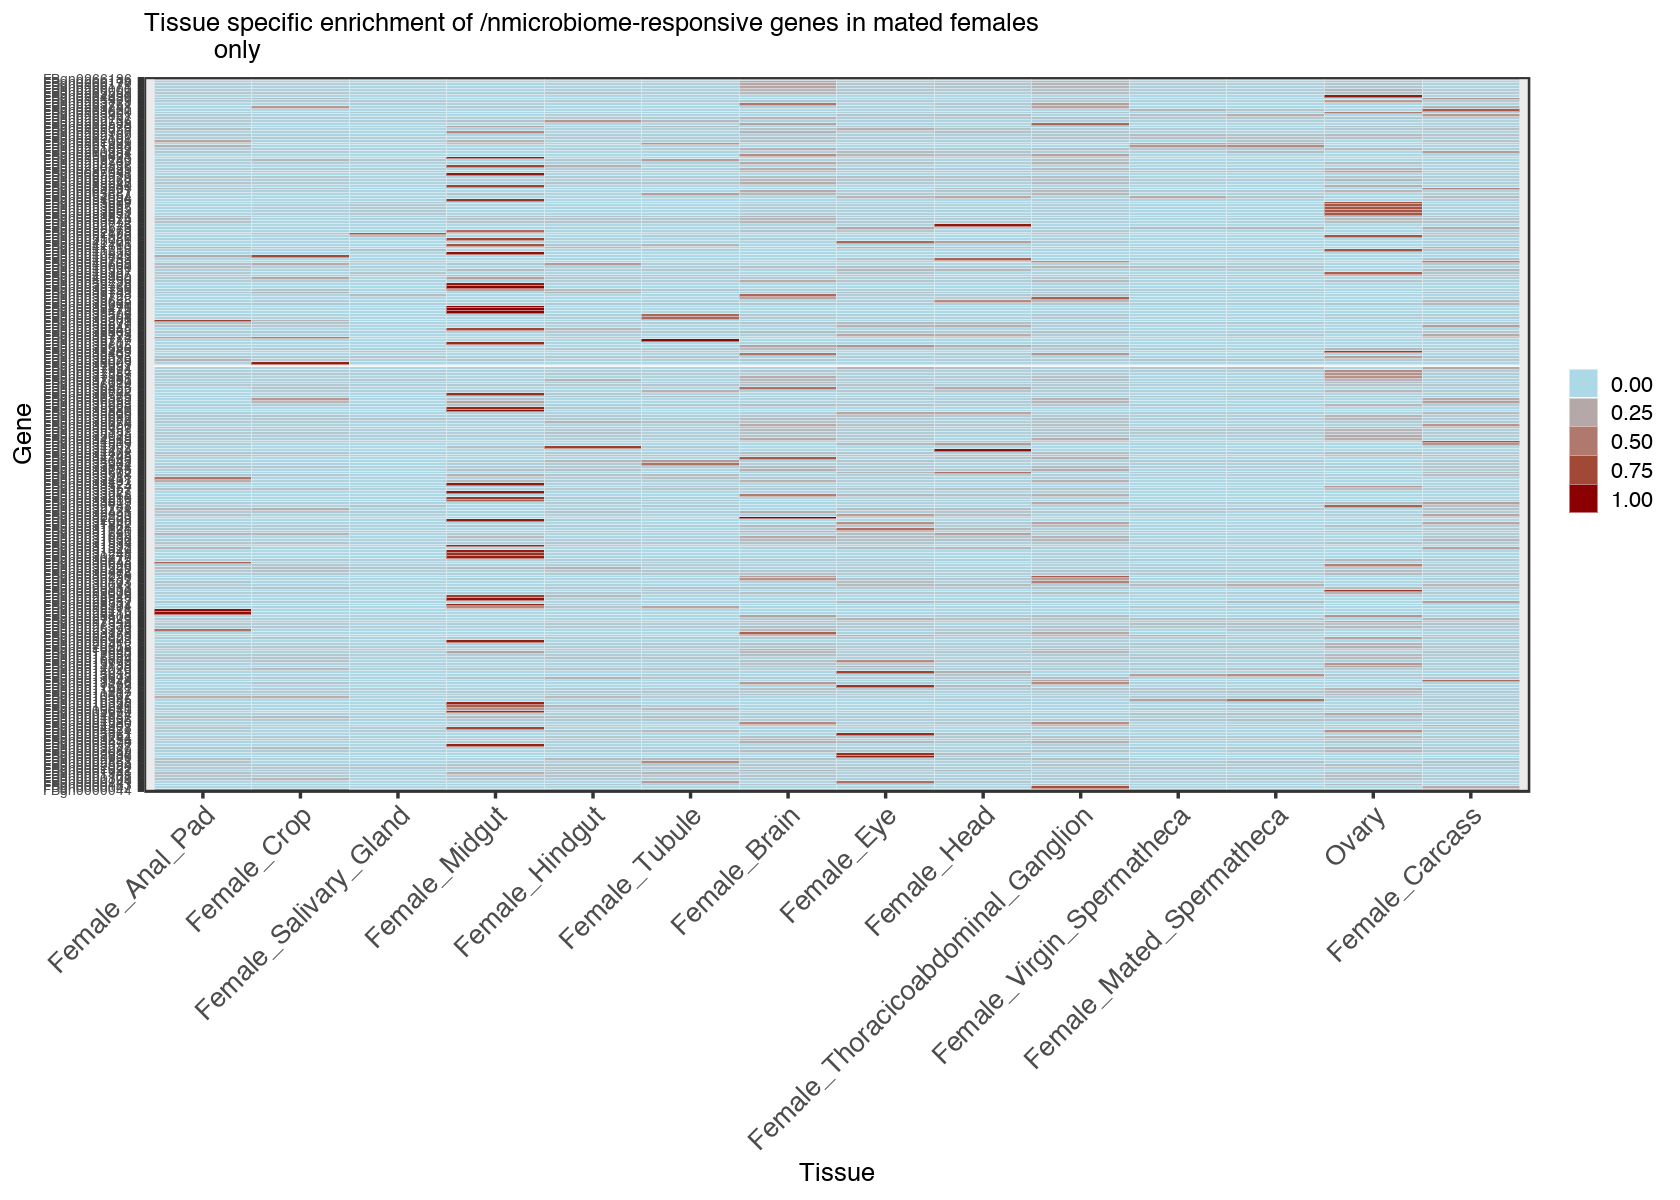

In [97]:
options(repr.plot.width = 14, repr.plot.height =10)
ggplot(data_long, aes(Tissue, Gene)) + 
  geom_tile(aes(fill = as.numeric(as.character(Enrichment))),
            colour = "white") + 
  scale_fill_gradient(low="lightblue", high="darkred", na.value="grey95")+
  ggtitle("Tissue specific enrichment of /nmicrobiome-responsive genes in mated females 
          only")+
  theme(plot.title = element_text(size=15))+
  guides(fill=guide_legend(title=NULL))+
  theme(legend.title=element_blank())+
  theme(axis.text.x=element_text(hjust=1, size = 16, angle=45, face="bold"), axis.title.y =
          element_text(size=15, face = "bold"), axis.title.x = element_text(size=15, face =
                                                                              "bold"), 
        axis.text.y  = element_text(size=8))

In [98]:
Enrichment_by_tissue <- apply(Enrichment_DE, 1, function(x) mean(x, na.rm = T))
DE_tissue_dat <- cbind(colnames(FlyAtlas_DE), Enrichment_by_tissue)
rownames(DE_tissue_dat) <- NULL
colnames(DE_tissue_dat) <- c("Tissue", "Enrichment_by_tissue")
Tissue_dat <- cbind(DE_tissue_dat, c(rep("Female", 14)))
colnames(Tissue_dat) <- c("Tissue", "Enrichment", "Group")


In [99]:
head(Tissue_dat)

Tissue,Enrichment,Group
Female_Anal_Pad,0.0655760840769535,Female
Female_Crop,0.0555485873511108,Female
Female_Salivary_Gland,0.0256187368046483,Female
Female_Midgut,0.166058233814236,Female
Female_Hindgut,0.0503403811606518,Female
Female_Tubule,0.055538277894122,Female


In [100]:
cal_z_score <- function(x){
   (x - mean(x)) / sd(x)
}

Z_score_F <- cal_z_score(as.numeric(as.character(Tissue_dat[1:14,2])))

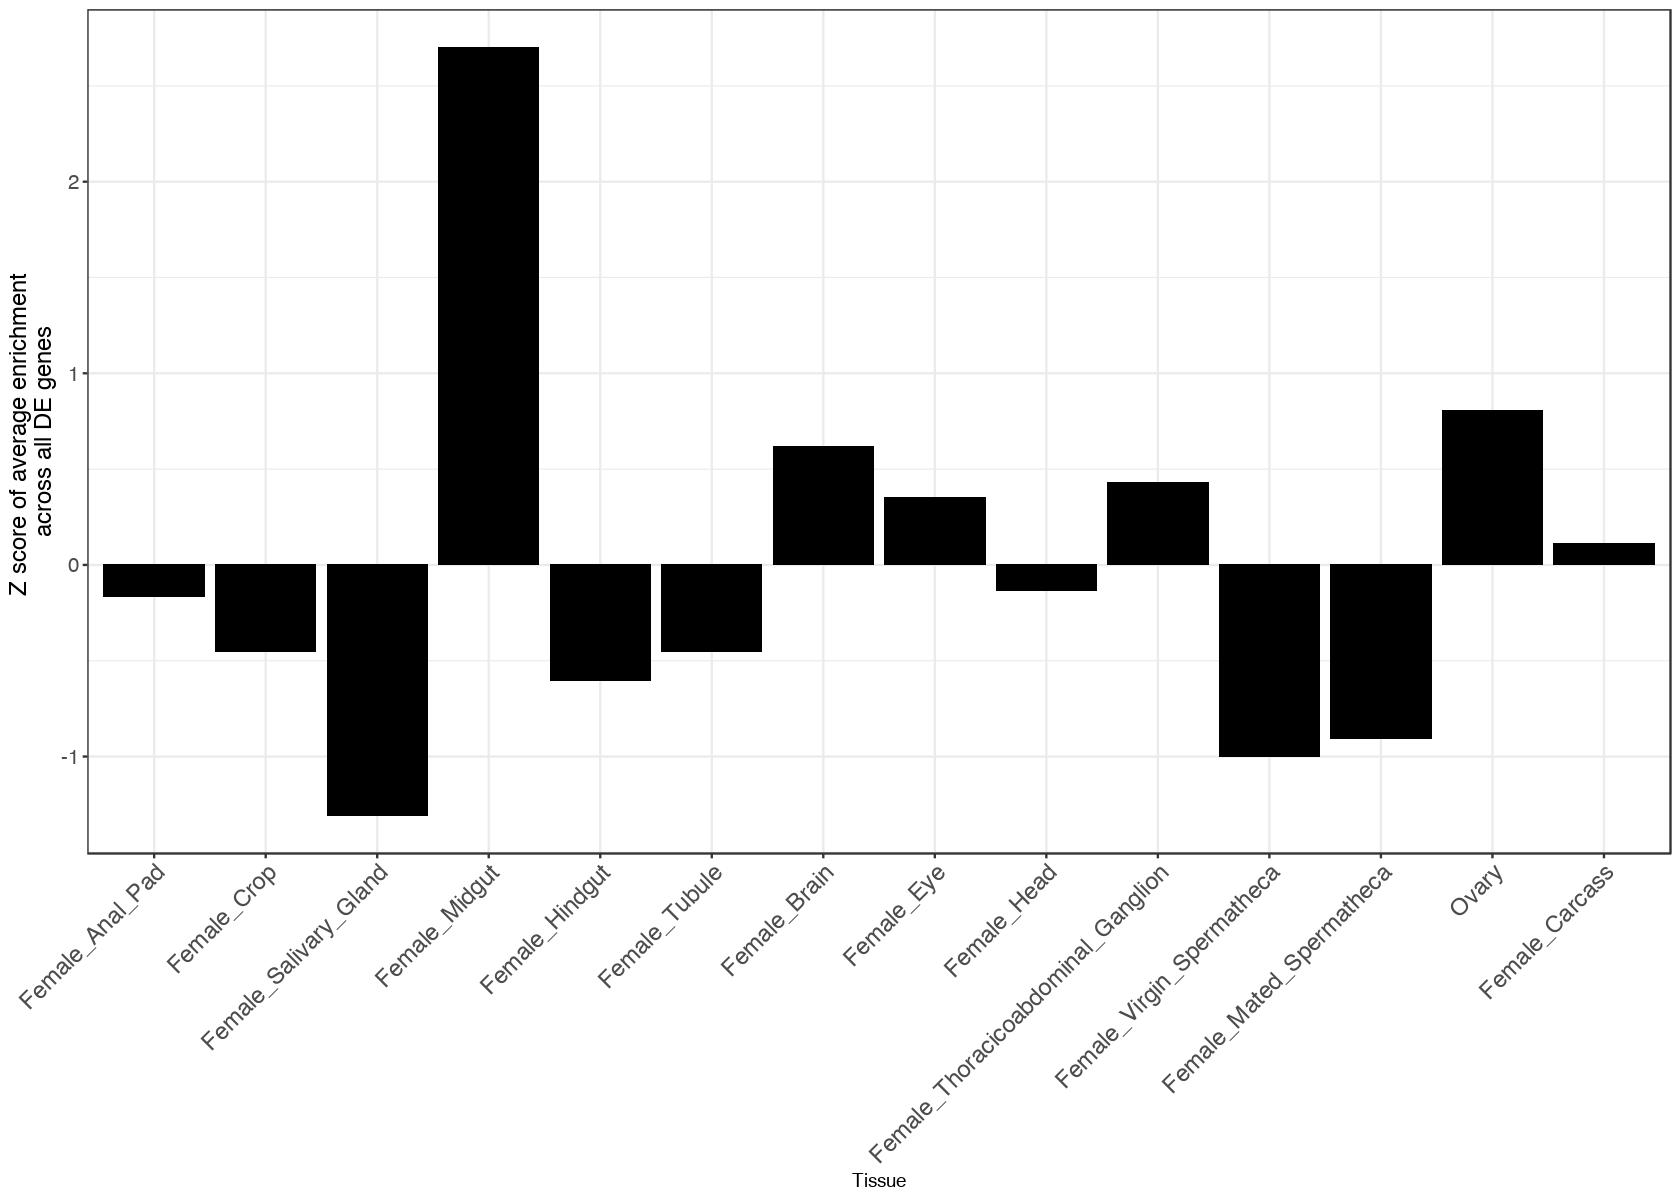

In [102]:
Tissue_dat <- cbind(Tissue_dat, Z_score_F)
Tissue_dat <- as.data.frame(Tissue_dat)
Tissue_dat$Tissue <- factor(Tissue_dat$Tissue, levels = unique(Tissue_dat$Tissue))

ggplot(data=Tissue_dat, aes(x=Tissue, y=as.numeric(as.character(Z_score_F)), fill=Group)) +
  geom_bar(stat="identity")+
  theme_bw()+
  scale_fill_manual(values=c("gray0", "gray0"))+
  theme(axis.text.x=element_text(hjust=1, size = 14, angle=45, face="bold"),
         axis.text.y = element_text(size = 12),
         axis.title.y = element_text(size = 14)) +
  guides(fill=F)+
  ylab("Z score of average enrichment \nacross all DE genes")

In [103]:
col_fun = colorRamp2(c(-2, 0, 2), c("red", "white", "blue"))

rownames(test) <- test[,1]
test <- test[,-1]
write.table(test, file="Heatmap_input.txt", row.names=T, quote=F, sep="\t")
dat <- read.delim("Heatmap_input.txt", header=T, as.is=T)

row_ha = rowAnnotation(bar2 = anno_barplot(Z_score_F), which="Row")

ha = HeatmapAnnotation(foo = anno_barplot(Z_score_F), bar_width = 1, height = unit(6, "cm"))

Heatmap(as.matrix(dat), na_col="white", cluster_rows = F, cluster_columns = F, col=col_fun,
        name="Enrichment value", top_annotation = HeatmapAnnotation(foo = anno_block(gp = gpar(fill = 2:4))))

ERROR: Error in HeatmapAnnotation(..., which = "row"): formal argument "which" matched by multiple actual arguments


##### Cluster analysis:

Another approach is to generate K-means clusters of DE genes. We'll first extract the TPM matrix for DE geenes:

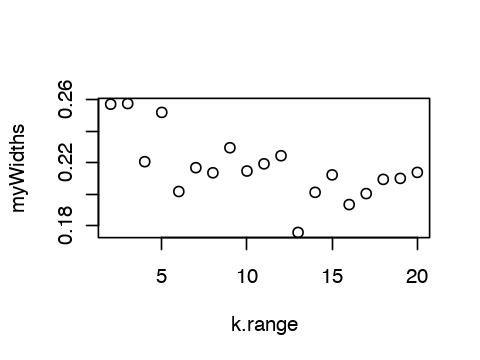

In [102]:
PM_DEgenes = union(c(AA.v.AO_sigGenes, AC.v.AO_sigGenes), c(CA.v.CO_sigGenes, CC.v.CO_sigGenes))
PM_DEgenes_matrix = subset(tpmMatrix_mean, rownames(tpm_bt2) %in% PM_DEgenes)
options(repr.plot.width = 4, repr.plot.height = 3)
findK(PM_DEgenes_matrix)

Now run the cluster analysis:

In [103]:
kmeans_data = PM_DEgenes_matrix
kmeans_data = log2(kmeans_data+1)
kmeans_data = as.matrix(kmeans_data) # convert to matrix
kmeans_data = t(scale(t(kmeans_data), scale=F))
sample_cor = cor(kmeans_data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(kmeans_data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=6)
## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Make a new object with the gene names and cluster assignments, and the centered log2 TPM values:

In [104]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = kmeans_data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_PM_DE_data = rbindlist(cluster_list)

Now generate a dataframe for easy plotting:

In [105]:
sampleInfo_clusters = unique(select(sampleInfo, -Replicate, -Handler))

axenicSub = subset(cluster_PM_DE_data, select = c("Gene_ID", "cluster", "AO", "AA", "AC"))
controlSub = subset(cluster_PM_DE_data, select = c("Gene_ID", "cluster", "CO", "CC", "CA"))
df.axenicSub = melt(axenicSub, id.vars = c("Gene_ID", "cluster"))
df.controlSub = melt(controlSub, id.vars = c("Gene_ID", "cluster"))
df.Sub = rbind(df.axenicSub, df.controlSub)
df.Sub = merge(df.Sub, sampleInfo_clusters, by.x = "variable", by.y = "Sample")

Now plot it:

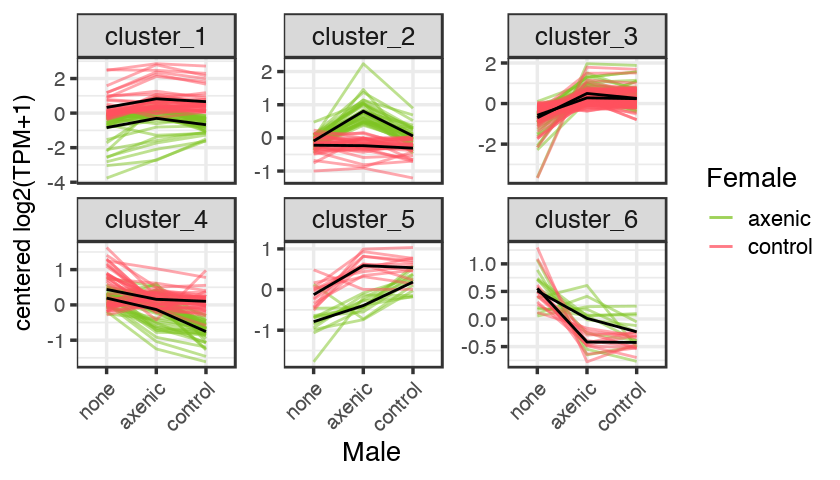

In [107]:
df.Sub$Male = factor(df.Sub$Male, levels = c("none", "axenic", "control"))

options(repr.plot.width = 7, repr.plot.height = 4)
# pdf("Results/Figures/cluster_groupings.pdf", width = 7, height = 4)
ggplot() + 
    geom_line(data = subset(df.Sub, Female == "axenic"),
              aes(Male, value, group = Gene_ID, colour = "#7ec323"), 
              alpha = 0.5,
              size = 0.6) +
    geom_line(data = subset(df.Sub, Female == "control"), 
              aes(Male, value, group = Gene_ID, colour = "#ff505e"),
              alpha = 0.5,
              size = 0.6) +
#     theme_monokai_full() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
#     scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=45,hjust=1, size = 12),
         axis.text.y = element_text(size = 12),
#          axis.title.x = element_blank(),
         axis.title.y = element_text(size = 14),
         strip.text = element_text(size = 15)) +
    stat_summary(data = df.Sub, 
                 aes(x=Male,y=value,group=Female),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.5,
                 size=0.6,
                 geom="smooth") +
    ylab("centered log2(TPM+1)") +
    scale_colour_manual(name = 'Female', 
         values =c("#7ec323"="#7ec323","#ff505e"="#ff505e"), labels = c('axenic','control'))
# dev.off()

Output individual gene plots by cluster:

In [ ]:
DE.genes_up_C1_boxPlots = suppressMessages(lapply(unique(df.Sub$Gene_ID[df.Sub$cluster == "cluster_1"]), geneBarPlot_mon, show_reps = T))
ggsave("Results/Figures/PM_DEgenes_C1_barPlots.pdf", marrangeGrob(grobs = DE.genes_up_C1_boxPlots, nrow = 2, ncol =1))

DE.genes_up_C2_boxPlots = suppressMessages(lapply(unique(df.Sub$Gene_ID[df.Sub$cluster == "cluster_2"]), geneBarPlot_mon, show_reps = T))
ggsave("Results/Figures/PM_DEgenes_C2_barPlots.pdf", marrangeGrob(grobs = DE.genes_up_C2_boxPlots, nrow = 2, ncol =1))

DE.genes_up_C3_boxPlots = suppressMessages(lapply(unique(df.Sub$Gene_ID[df.Sub$cluster == "cluster_3"]), geneBarPlot_mon, show_reps = T))
ggsave("Results/Figures/PM_DEgenes_C3_barPlots.pdf", marrangeGrob(grobs = DE.genes_up_C3_boxPlots, nrow = 2, ncol =1))

DE.genes_up_C4_boxPlots = suppressMessages(lapply(unique(df.Sub$Gene_ID[df.Sub$cluster == "cluster_4"]), geneBarPlot_mon, show_reps = T))
ggsave("Results/Figures/PM_DEgenes_C4_barPlots.pdf", marrangeGrob(grobs = DE.genes_up_C4_boxPlots, nrow = 2, ncol =1))

DE.genes_up_C5_boxPlots = suppressMessages(lapply(unique(df.Sub$Gene_ID[df.Sub$cluster == "cluster_5"]), geneBarPlot_mon,show_reps = T))
ggsave("Results/Figures/PM_DEgenes_C5_barPlots.pdf", marrangeGrob(grobs = DE.genes_up_C5_boxPlots, nrow = 2, ncol =1))

In [115]:
mated_sigGenes_fa2 = subset(tpm.matrix_fa2.female_tissues, rownames() %in% mated_sigGenes)
# Enrichment_DE <- apply(mated_sigGenes_fa2, 1, function(x) x/sum(x))
# Enrichment_DE[is.infinite(Enrichment_DE)]<-NA
head(Enrichment_DE)

ERROR: Error in rownames(): argument "x" is missing, with no default


In [117]:
DE <- read.delim("Sofie_RUVseq/Tissue\ Enrichment/DE_mated.txt", header=T, as.is=T)
DE <- DE[,1]

# Retrieve tissues of interest from flyAtlas
FlyAtlas <- read.delim("Annotoations/FlyAtlas2_meanTPM_table.txt", header=T, as.is=T)
FlyAtlas <- FlyAtlas[,c(c(1:13, 38))]
FlyAtlas.2 <- cbind(FlyAtlas[,4],  FlyAtlas[,10], FlyAtlas[,9], FlyAtlas[,7], FlyAtlas[,1],
                    FlyAtlas[,12], FlyAtlas[,2], FlyAtlas[,5], FlyAtlas[,6], FlyAtlas[,11],
                    FlyAtlas[,13], FlyAtlas[,8], FlyAtlas[,14], FlyAtlas[,3])
colnames(FlyAtlas.2) <- c( "F_Crop", "F_Salivary_gland", "F_Midgut", "F_Hindgut",
                           "F_Rectal_pad",  "F_Tubule", "F_Brain", "F_Eye", "F_Head",
                           "F_Thoracicoabdominal_ganglion", "F_Virgin_spermathecae",
                           "F_Mated_spermathecae", "F_Ovary", "F_Carcass")
rownames(FlyAtlas.2) <- rownames(FlyAtlas)

# Calculate enrichment of DE genes in female and male tissues
FlyAtlas_DE <- FlyAtlas.2[rownames(FlyAtlas.2) %in% DE,]
Enrichment_DE <- apply(FlyAtlas_DE, 1, function(x) x/sum(x))
Enrichment_DE[is.infinite(Enrichment_DE)]<-NA

In [118]:
head(Enrichment_DE)

,FBgn0000044,FBgn0000047,FBgn0000183,FBgn0000241,FBgn0000308,FBgn0001108,FBgn0001941,FBgn0001992,FBgn0002022,FBgn0002524,⋯,FBgn0263761,FBgn0263979,FBgn0264489,FBgn0264696,FBgn0265598,FBgn0266000,FBgn0266171,FBgn0266172,FBgn0266178,FBgn0266186
F_Crop,0.441535560,0.0077799611,0.06268377,0.003761035,0.16675225,0.07167353,0.05042397,0.08593920,0.07909639,0.06641426,⋯,0.009455961,0.06136722,0.13063340,0.0028424638,0.07480697,0.04877910,0.04119071,0.04119071,0.04119071,0.09640773
F_Salivary_gland,0.003005483,0.0083567356,0.04021121,0.003800598,0.02601758,0.03421034,0.01708115,0.04198383,0.07727892,0.06070277,⋯,0.047372392,0.06073248,0.02048566,0.0051921082,0.03334839,0.02649560,0.02651061,0.02651061,0.02651061,0.03695508
F_Midgut,0.016769432,0.0000000000,0.04518363,0.004177856,0.08843599,0.05517600,0.21712949,0.02886070,0.07578680,0.10150875,⋯,0.019503991,0.03850152,0.01631110,0.0000000000,0.03811505,0.02197056,0.01463424,0.01463424,0.01463424,0.07063197
F_Hindgut,0.068109476,0.0003729425,0.08619694,0.003899085,0.04994525,0.09946808,0.10716104,0.11004071,0.07105234,0.08826703,⋯,0.005029484,0.05737871,0.03203995,0.0001691131,0.08399350,0.04242257,0.03296245,0.03296245,0.03296245,0.08143912
F_Rectal_pad,0.332008039,0.0029516607,0.03799218,0.002648828,0.09593912,0.08295026,0.11862555,0.05957428,0.07002070,0.06790807,⋯,0.001735709,0.05199566,0.10566172,0.0101134568,0.06631574,0.05575351,0.04161663,0.04161663,0.04161663,0.10374353
F_Tubule,0.002684392,0.0004948062,0.07160570,0.305037127,0.05550695,0.07715239,0.18148029,0.04275302,0.09639462,0.07473891,⋯,0.001017811,0.04384814,0.05018907,0.0174117091,0.04612355,0.03396370,0.03733913,0.03733913,0.03733913,0.05210761


In [120]:
test<- cbind(rownames(Enrichment_DE), Enrichment_DE)
rownames(test) <- NULL
colnames(test) <- c("Tissue", colnames(Enrichment_DE))
test <- as.data.frame(test)
# colnames(test)
data_long <- gather(test, Gene, Enrichment,
                    colnames(test)[2]:colnames(test)[length(colnames(test))], 
                    factor_key=TRUE)
data_long$Tissue<- factor(data_long$Tissue, levels = unique(data_long$Tissue))


Warning message:
"attributes are not identical across measure variables;
they will be dropped"


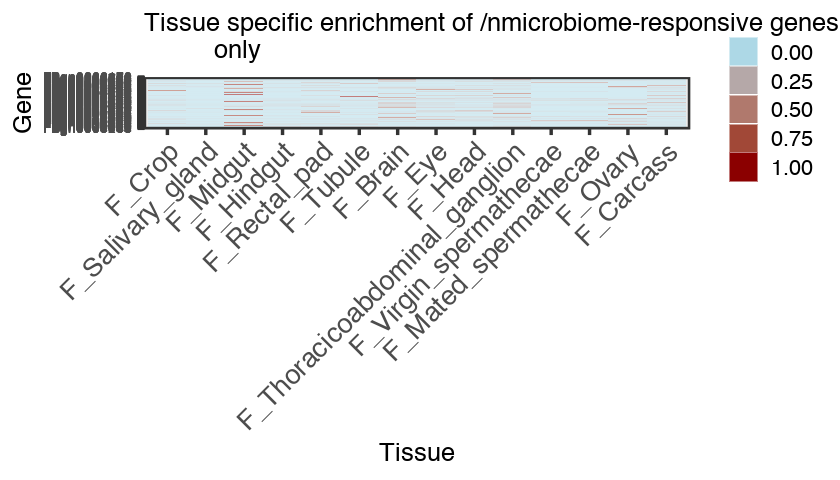

In [121]:
ggplot(data_long, aes(Tissue, Gene)) + 
  geom_tile(aes(fill = as.numeric(as.character(Enrichment))),
            colour = "white") + 
  scale_fill_gradient(low="lightblue", high="darkred", na.value="grey95")+
  ggtitle("Tissue specific enrichment of /nmicrobiome-responsive genes in mated females 
          only")+
  theme(plot.title = element_text(size=15))+
  guides(fill=guide_legend(title=NULL))+
  theme(legend.title=element_blank())+
  theme(axis.text.x=element_text(hjust=1, size = 16, angle=45, face="bold"), axis.title.y =
          element_text(size=15, face = "bold"), axis.title.x = element_text(size=15, face =
                                                                              "bold"), 
        axis.text.y  = element_text(size=8))

# Appendix:

##### Genes causing batch effect:

We'll identify the genes that are causing the batch between 1-2 and 3-4. 

In [182]:
# add a column specifying the sample batch grouping
sampleInfo2 = sampleInfo
sampleInfo2$repGroup = paste(sampleInfo2$Sample, sampleInfo2$Handler, sep = ".")
# set up design matrix for this comparison
repGroups = factor(sampleInfo2$repGroup)
design_reps = model.matrix( ~ 0 + repGroups)
colnames(design_reps) <- levels(repGroups)
rownames(design_reps) <- sampleInfo$Replicate

## Now make the DGE object:
dgeList_rG <- DGEList(counts = countsKeep_bt2, group = repGroups)
dgeList_rG <- calcNormFactors(dgeList_rG)
dgeList_rG <- estimateGLMCommonDisp(dgeList_rG, design_reps)
dgeList_rG <- estimateGLMTagwiseDisp(dgeList_rG, design_reps)
dgeList_rG_fit <- glmQLFit(dgeList_rG, design_reps)
summary(dgeList_rG$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02253 0.04009 0.05096 0.07014 0.07450 2.25541 

Now we'll make the desired contrasts between handler's for each sample group:

In [183]:
AO_contrasts <- makeContrasts(AO.Sofie-AO.Yasir, levels=design_reps)
AA_contrasts <- makeContrasts(AA.Sofie-AA.Yasir, levels=design_reps)
AC_contrasts <- makeContrasts(AC.Sofie-AC.Yasir, levels=design_reps)

CO_contrasts <- makeContrasts(CO.Sofie-CO.Yasir, levels=design_reps)
CA_contrasts <- makeContrasts(CA.Sofie-CA.Yasir, levels=design_reps)
CC_contrasts <- makeContrasts(CC.Sofie-CC.Yasir, levels=design_reps)

Run the DE test and make lists of significant genes for each contrast:

In [184]:
# run the LRT and extract the DE table
lrt.AO.table <- edge.DE(dgeList_rG_fit, AO_contrasts)
AO_sigGenes = subset(lrt.AO.table, sig == "yes" & logFC > 0)$gene

lrt.AA.table <- edge.DE(dgeList_rG_fit, AA_contrasts)
AA_sigGenes = subset(lrt.AA.table, sig == "yes" & logFC > 0)$gene

lrt.AC.table <- edge.DE(dgeList_rG_fit, AC_contrasts)
AC_sigGenes = subset(lrt.AC.table, sig == "yes" & logFC > 0)$gene

lrt.CO.table <- edge.DE(dgeList_rG_fit, CO_contrasts)
CO_sigGenes = subset(lrt.CO.table, sig == "yes" & logFC > 0)$gene

lrt.CA.table <- edge.DE(dgeList_rG_fit, CA_contrasts)
CA_sigGenes = subset(lrt.CA.table, sig == "yes" & logFC > 0)$gene

lrt.CC.table <- edge.DE(dgeList_rG_fit, CC_contrasts)
CC_sigGenes = subset(lrt.CC.table, sig == "yes" & logFC > 0)$gene

We can look at volcano plots of DE genes:

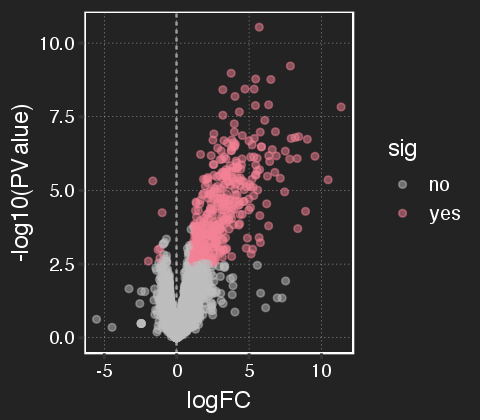

In [185]:
options(repr.plot.width = 4, repr.plot.height = 3.5)
edge.DE.gg(lrt.AC.table) +
    scale_colour_manual(values = c("gray","#f38195")) +
    theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

We can use Venn diagrams or output a summary of the overlaps:

In [186]:
rogue_candidates <- list(mated = mated_sigGenes, 
                        virgins = virgins_sigGenes)

rogue_Vdiag<-venn.diagram(rogue_candidates, NULL, fill=c("#a3181b", "#afd360"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

rogue_combs <- unlist(lapply(1:length(rogue_candidates), function(j) combn(names(rogue_candidates), j, simplify = FALSE)), recursive = FALSE)
names(rogue_combs) <- sapply(rogue_combs, function(i) paste0(i, collapse = ","))
rogue_elements <- lapply(rogue_combs, function(i) Setdiff(rogue_candidates[i], rogue_candidates[setdiff(names(rogue_candidates), i)]))
options(repr.plot.width = 3, repr.plot.height =2)
summary(rogue_elements)
grid.arrange(gTree(children=rogue_Vdiag))
rm(rogue_candidates, rogue_Vdiag, rogue_combs)

ERROR: Error in eval(expr, envir, enclos): object 'mated_sigGenes' not found


Output a table of all rogue genes by sample:

In [187]:
rogue_candidates <- list(AO = AO_sigGenes, 
                        CO = CO_sigGenes,
                        AA = AA_sigGenes,
                        AC = AC_sigGenes,
                        CC = CC_sigGenes,
                        CA = CA_sigGenes)
rogue_combs <- unlist(lapply(1:length(rogue_candidates), function(j) combn(names(rogue_candidates), j, simplify = FALSE)), recursive = FALSE)
names(rogue_combs) <- sapply(rogue_combs, function(i) paste0(i, collapse = ","))
rogue_elements <- lapply(rogue_combs, function(i) Setdiff(rogue_candidates[i], rogue_candidates[setdiff(names(rogue_candidates), i)]))
rogue_gene_table = as.data.frame(unlist(rogue_elements))
rogue_gene_table$samples = rownames(rogue_gene_table)
rogue_gene_table$samples = gsub('[[:digit:]]+', '', rogue_gene_table$samples)
colnames(rogue_gene_table) = c("FBgn_ID", "sample")
rownames(rogue_gene_table) = NULL
# write.table(rogue_gene_table, "Results/Tables/rogue_genes.txt", sep = "\t", quote = F, row.names = F)

Let's see what GO terms are enriched among these rogue genes, and write out to file:

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


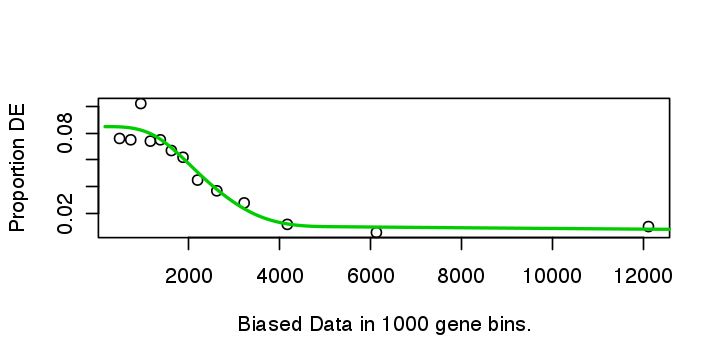

In [188]:
rogue_genes = union(c(AO_sigGenes, AA_sigGenes, AC_sigGenes), c(CO_sigGenes, CC_sigGenes, CA_sigGenes))
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% rogue_genes)
pwf=nullp(DEgenes = cat_genes_vec, bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)

In [189]:
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
rogue_sigGenes_enrich_result_table = res[res$over_represented_pvalue<=0.05,]
head(subset(rogue_sigGenes_enrich_result_table, over_represented_FDR < 0.05))
# write.table(subset(rogue_sigGenes_enrich_result_table, over_represented_FDR < 0.05), "Results/Tables/rogue_genes_GO_enirchment.txt", quote = F, sep = "\t", row.names = F)

,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_FDR
1715,GO:0006508,9.775252e-40,1,103,461,proteolysis,BP,7.826067e-36
741,GO:0004252,6.883179e-28,1,71,277,serine-type endopeptidase activity,MF,2.755337e-24
1262,GO:0005576,6.397290e-19,1,75,451,extracellular region,CC,1.707223e-15
1266,GO:0005615,1.241745e-14,1,77,554,extracellular space,CC,2.485353e-11
6654,GO:0055114,2.390857e-14,1,56,385,oxidation-reduction process,BP,3.828241e-11
5303,GO:0042600,1.808709e-13,1,18,39,chorion,CC,2.413421e-10


ALso look at KEGG pathway enrichment. First get the organism ID for _D. mel_:

In [190]:
search_kegg_organism('fruit fly', by = 'common_name')

,kegg_code,scientific_name,common_name
86,dme,Drosophila melanogaster,fruit fly


Get the appropriate FlyBase ID first:

In [191]:
rogue_genes_altIDs = subset(annotation, primary_FBgn %in% rogue_genes & !is.na(annotation_ID))
rogue_genes_altIDs = paste(rogue_genes_altIDs$organism_abbreviation, rogue_genes_altIDs$annotation_ID, sep = "_")
rogue_kegg <- enrichKEGG(gene = rogue_genes_altIDs, organism = 'dme')
# write.table(rogue_kegg, "Results/Tables/rogue_genes_KEGG_enirchment.txt", quote = F, sep = "\t", row.names = F)

In [48]:



CC.v.AA_contrasts <- makeContrasts(CC-AA, levels=design_2)

CC.v.CA_contrasts <- makeContrasts(CC-CA, levels=design_2)
CC.v.AC_contrasts <- makeContrasts(CC-AC, levels=design_2)

AA.v.CA_contrasts <- makeContrasts(AA-CA, levels=design_2)


# male effect
male.effect.A.background <- makeContrasts( AC-AA, levels = design_2)
male.effect.C.background <- makeContrasts( CC-CA, levels = design_2)

# female effect:
A.female.effect <- makeContrasts( ((AA-AO)+(AC-AO))/2 - ((CA-CO)+(CC-CO))/2, levels = design_2)
A.male.effect <- makeContrasts( ((AA-AO)+(CA-CO))/2 - ((CC-CO)+(AC-AO))/2, levels = design_2)

# mated female effect:
AA.effect <- makeContrasts( (AA-AO) - ((AC-AO)+(CC-CO)+(CA-CO))/3, levels=design_2)
AC.effect <- makeContrasts( (AC-AO) - ((AA-AO)+(CC-CO)+(CA-CO))/3, levels=design_2)
CA.effect <- makeContrasts( (CA-CO) - ((AC-AO)+(CC-CO)+(AA-AO))/3, levels=design_2)
CC.effect <- makeContrasts( (CC-CO) - ((AC-AO)+(AA-AO)+(CA-CO))/3, levels=design_2)